### <center> **Data Mining - Customer Segmentation** </center>

---

**<center> Author: Aravindan Natarajan </center>**
**<center>Version: 2.0</center>**

---

### **Data Summary**

A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. We have to identify the segments based on credit card usage

**<center> Data Dictionary </center>**

---

| # | Feature | Description | Units      |
|---|-------------------------------|-----------------------------------------------------------------------------------------------------------|------------|
| 1 | spending                      | Amount spent by the customer per month                                                                   | 1000s      |
| 2 | advance_payments              | Amount paid by the customer in advance by cash                                                            | 100s       |
| 3 | probability_of_full_payment | Probability of payment done in full by the customer to the bank                                          | -          |
| 4 | current_balance               | Balance amount left in the account to make purchases                                                      | 1000s      |
| 5 | credit_limit                  | Limit of the amount in credit card                                                                        | 10000s     |
| 6 | min_payment_amt               | Minimum paid by the customer while making payments for purchases made monthly                             | 100s       |
| 7 | max_spent_in_single_shopping  | Maximum amount spent in one purchase                                                                     | 1000s      |

### **1. Import the Required Libraries**

In [ ]:
# Import basic packages
import pandas as pd
import numpy as np
import itertools
from random import sample
from numpy.random import uniform

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
%matplotlib inline

# Set colour palette
palette = itertools.cycle(sns.color_palette())

# Import Statistical Packages
import statsmodels.api as sm
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

# Import Machine Learning Models
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors


# Warning handling
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **2. Some Useful Functions**

In [ ]:
# Annotation function to display the numbers above bar for bargraphs

def annotate_values(ax, orientation='v'):
  # Display counts at the top of the bars
  for p in ax.patches:
        if orientation == 'v':
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=8)

        elif orientation == 'h':
            ax.annotate(format(p.get_width(), '.0f'),
                        (p.get_width(), p.get_y() + p.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points',
                        fontsize=8)

In [ ]:
# Function for plotting a countplot

def plot_countplot(df, column, hue=None, hue_order=None):
  plt.figure(figsize=(10, 6))

  # If hue is provided, use it in the countplot
  if hue:
    counts = df.groupby([column, hue]).size().reset_index(name='count')
    order = counts.sort_values('count', ascending=False)[column].unique()
    ax = sns.countplot(x=column, data=df, order=order, hue=hue, hue_order=hue_order)
  else:
    counts = df[column].value_counts().sort_values(ascending=False)
    ax = sns.countplot(x=column, data=df, order=counts.index)

  plt.xticks(rotation=90)
  plt.title(f'Count Plot of {column}')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Count of {column}')
  annotate_values(ax)
  plt.show()

In [ ]:
# Function similar to plot_countplot named as plot_barplot

def plot_barplot(df, x_col, y_col, hue=None, hue_order=None):
    plt.figure(figsize=(10, 6))

    # Sort x_col values in ascending order
    order = df[x_col].sort_values().unique()

    if hue:
        ax = sns.barplot(x=x_col, y=y_col, data=df, hue=hue, hue_order=hue_order, order=order, palette='Set1',ci=None)  # ci=None removes error bars
    else:
        ax = sns.barplot(x=x_col, y=y_col, data=df, order=order, palette='Set1', ci=None)

    plt.xticks(rotation=90)
    plt.title(f'Bar Plot of {y_col} vs {x_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    annotate_values(ax)
    plt.show()

In [ ]:
# Function to annotate a Seaborn box plot with quartiles, IQR, maximum, and minimum values.

def annotate_boxplot(data_series, ax=None):

    # Calculate quartiles and IQR
    q1, q2, q3 = data_series.quantile([0.25, 0.5, 0.75])
    iqr = q3 - q1

    # Get minimum and maximum values
    data_min = data_series.min()
    data_max = data_series.max()

    # Get plot limits
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min

    # Adjust figure size based on x-range
    fig = plt.gcf()
    fig.set_size_inches(10 + x_range/20, 15)  # Adjust these values as needed

    # Annotate quartiles and IQR without arrows
    ax.text(q1, -0.3, f"Q1: {q1:.2f}", ha='center')
    ax.text(q2, 0.3, f"Q2 (Median): {q2:.2f}", ha='center')
    ax.text(q3, -0.4, f"Q3: {q3:.2f}", ha='center')
    #ax.text((q1+q3)/2, 0.3, f"IQR: {iqr:.2f}", ha='center', va='center')

    # Annotate minimum and maximum without arrows
    ax.text(data_min, -0.2, f"Min: {data_min:.2f}", ha='center')
    ax.text(data_max, 0.1, f"Max: {data_max:.2f}", ha='center')

    return ax

In [ ]:
# Detects outliers in a specified column of a DataFrame using the IQR method and returns a dataframe
def detect_outliers_iqr(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # Create a dataframe
    outlier_df = pd.DataFrame()
    outlier_df['% Upper Outlier'] = (((df[column] > upper_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Lower Outlier'] = (((df[column] < lower_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Total Outlier'] = (outlier_df['% Upper Outlier'] + outlier_df['% Lower Outlier']).round(2)

    # Sort by total outlier percentage
    outlier_df.sort_values(by='% Total Outlier', ascending=False)

    return outlier_df

### **3. Load the Data**

In [ ]:
# Load the dataset
bank_df = pd.read_csv('/content/drive/MyDrive/PGP-DSBA/Data Mining/Week 5/bank_marketing_part1_Data-1.csv')
bank_df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


### **4. Exploratory Data Analysis**

In [ ]:
# Shape of the dataset
rows, cols = bank_df.shape
print('There are {} rows and {} columns in the dataset'.format(rows, cols))

There are 210 rows and 7 columns in the dataset


In [ ]:
# Informstion about the dataset
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [ ]:
# Check for null values
bank_df.isnull().sum()

,0
spending,0
advance_payments,0
probability_of_full_payment,0
current_balance,0
credit_limit,0
min_payment_amt,0
max_spent_in_single_shopping,0


In [ ]:
# Check for any duplicated entries
bank_df.duplicated().any()

np.False_

**Summary**


* There are 210 rows and 7 columns in the dataset
* All the columns in the dataset are of float64 datatype
* There are no null values in the dataset
* There are no duplicate entries in the dataset

In [ ]:
# Create a list of columns for ease of handling
col_list = bank_df.columns.to_list()
col_list

['spending',
 'advance_payments',
 'probability_of_full_payment',
 'current_balance',
 'credit_limit',
 'min_payment_amt',
 'max_spent_in_single_shopping']

#### **4a. Univariate Analysis**

In [ ]:
# Statistical summary of the dataset
bank_df_stat = bank_df.describe().T
bank_df_stat['Skew']=bank_df.skew(axis=0)
bank_df_stat['Kurtosis']=bank_df.kurtosis(axis=0)
bank_df_stat

,count,mean,std,min,25%,50%,75%,max,Skew,Kurtosis
spending,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800,0.399889,-1.084266
advance_payments,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500,0.386573,-1.106703
probability_of_full_payment,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183,-0.537954,-0.140315
current_balance,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750,0.525482,-0.785645
credit_limit,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330,0.134378,-1.097697
min_payment_amt,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560,0.401667,-0.066603
max_spent_in_single_shopping,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500,0.561897,-0.840792


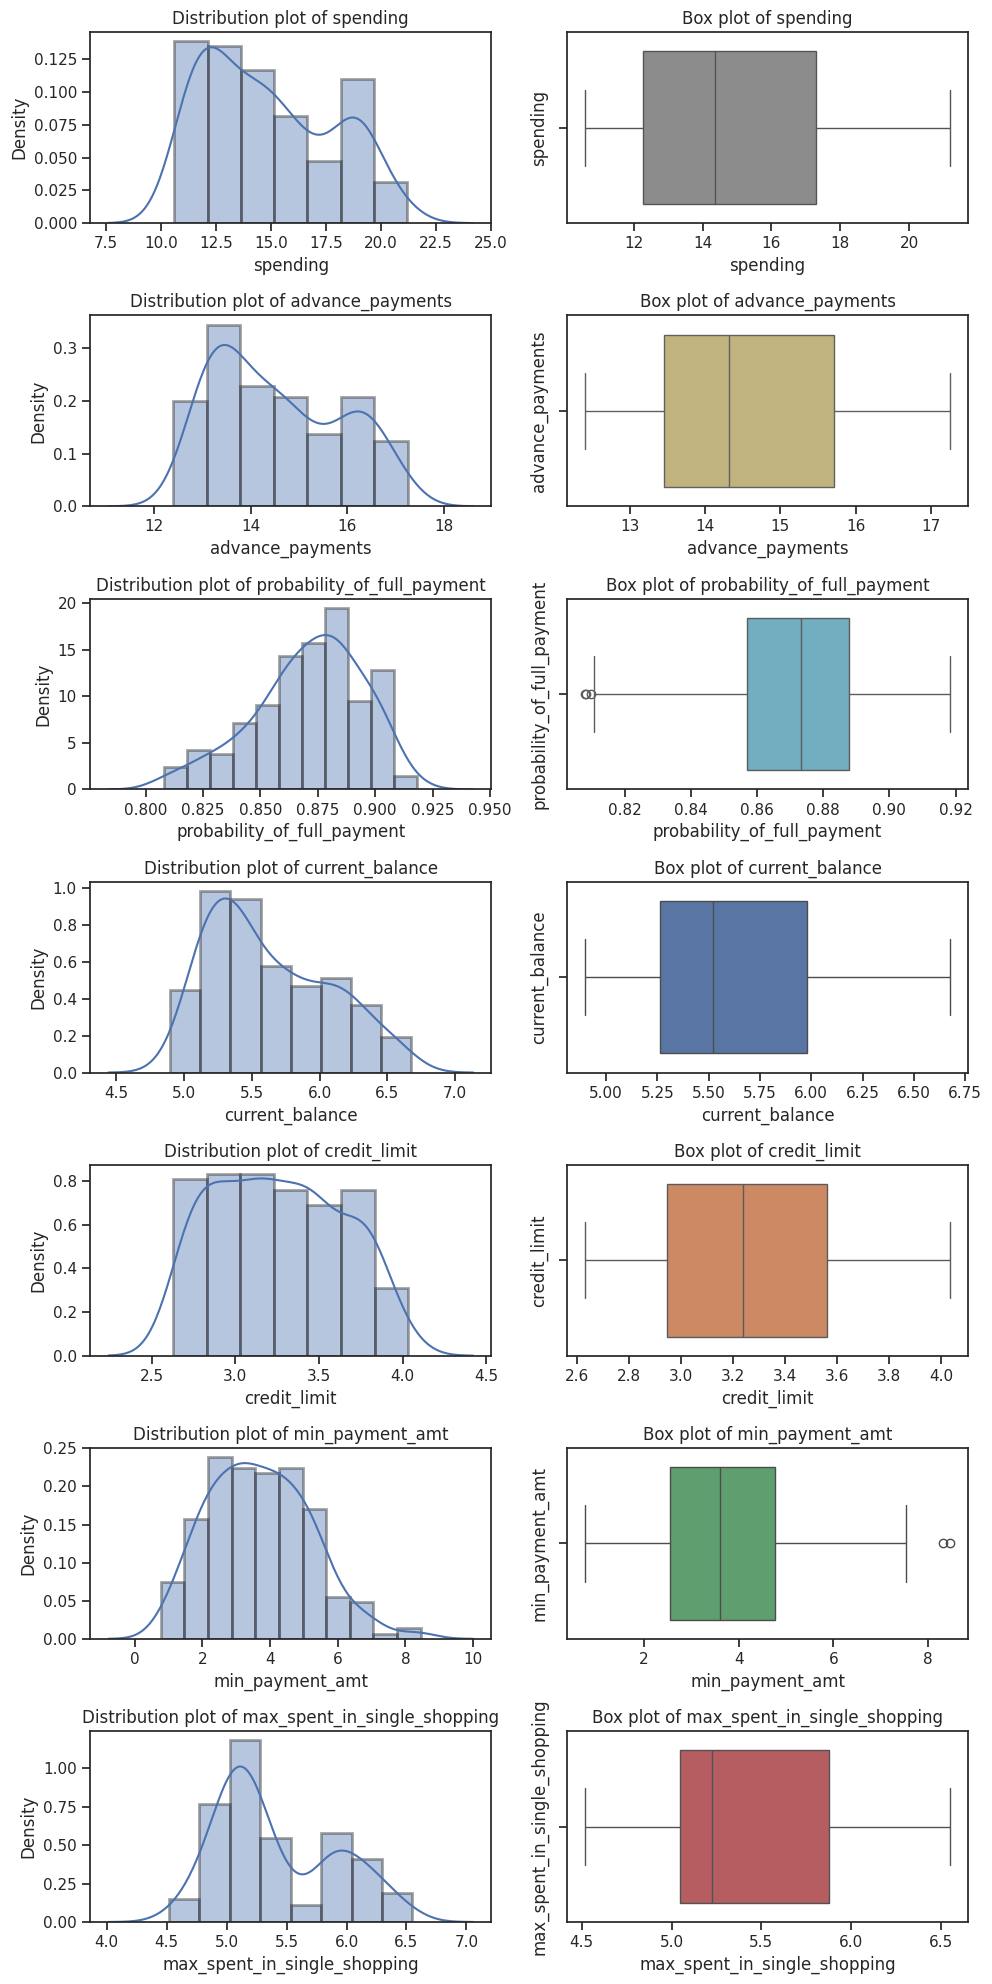

In [ ]:
# Distribution and boxplots of the variables

a = 7  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig1 = plt.figure(figsize=(10,20))

for i in col_list:
    plt.subplot(a, b, c)
    plt.title('Distribution plot of {}'.format(i))
    plt.xlabel(i)
    sns.distplot(bank_df[i], hist_kws=dict(edgecolor="k", linewidth=2))
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('Box plot of {}'.format(i))
    plt.ylabel(i)
    sns.boxplot(x = bank_df[i], orient='h', palette=palette)
    c = c + 1

plt.tight_layout()
plt.show()

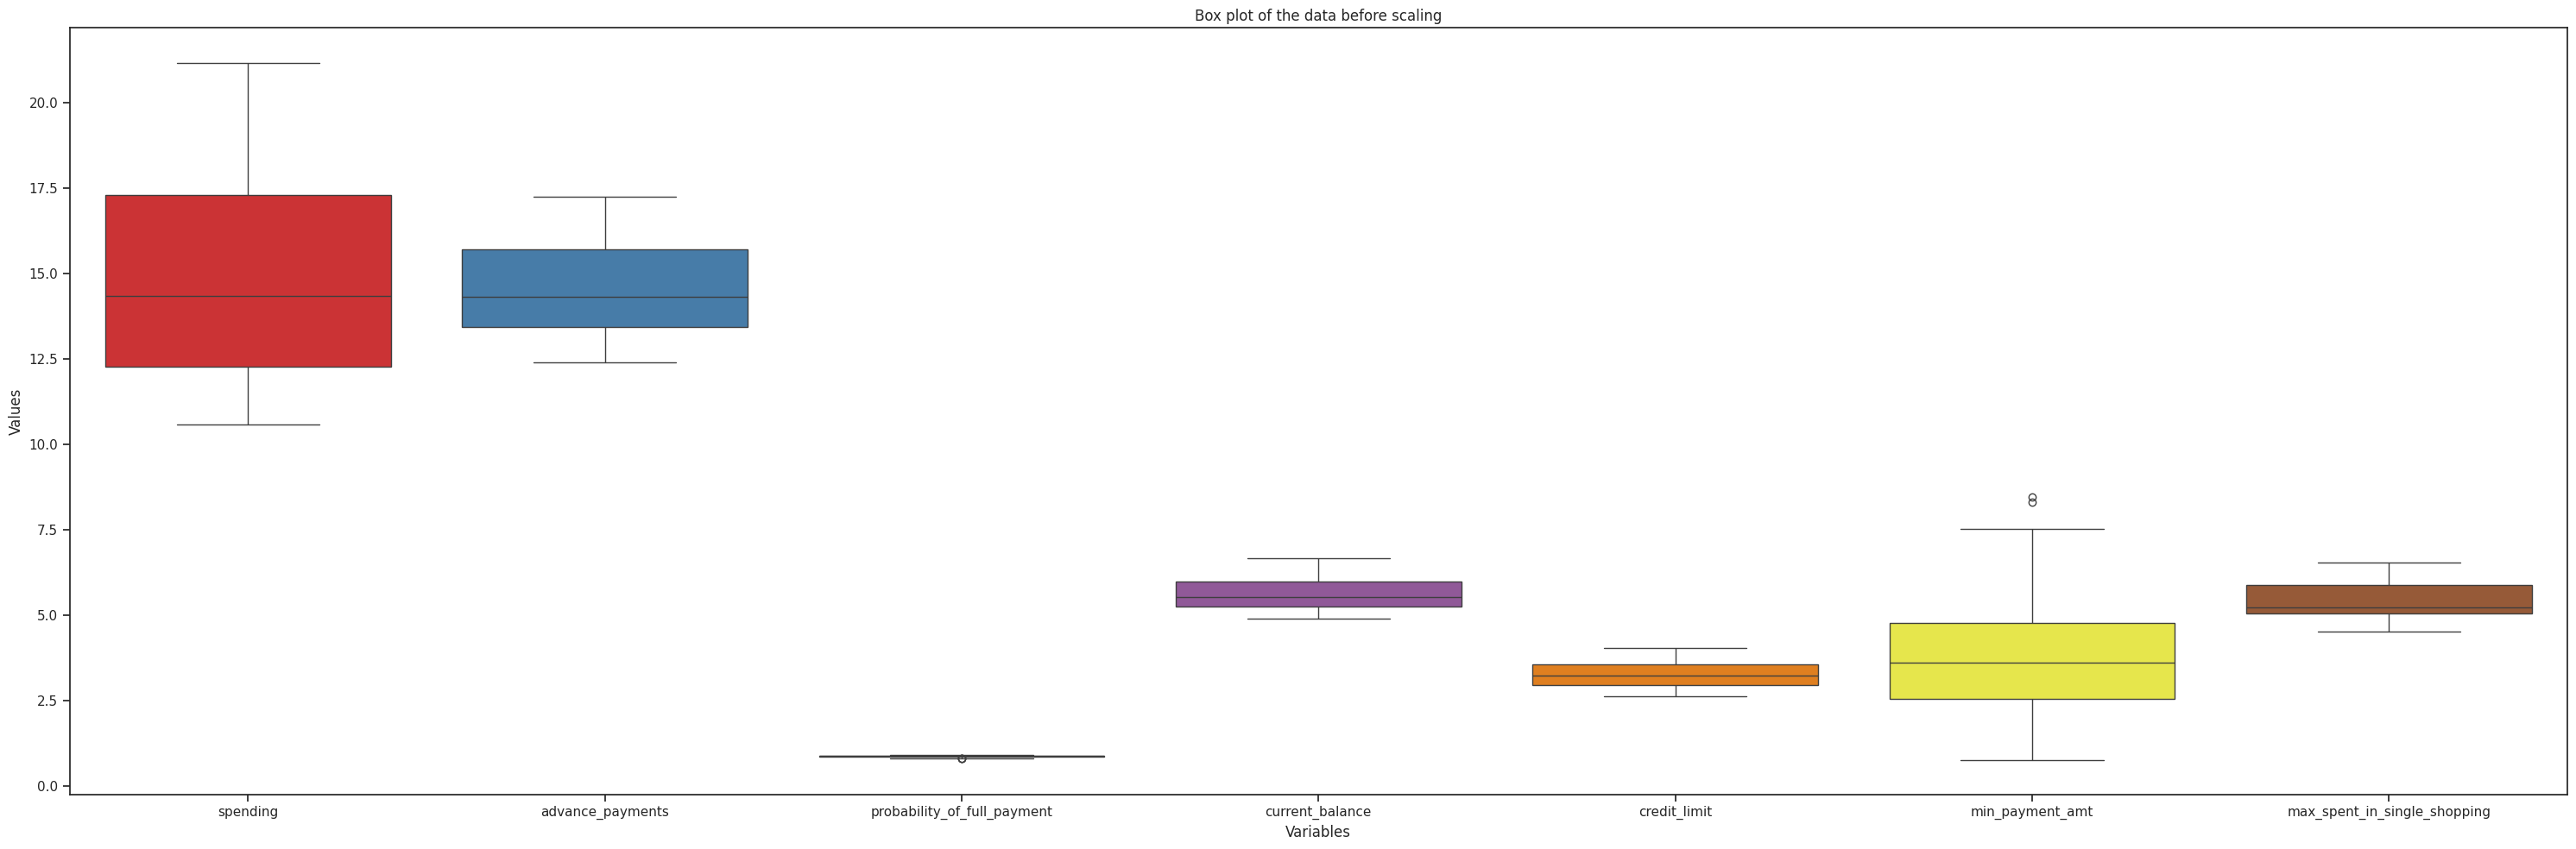

In [ ]:
# Box plot of the data before scaling
plt.figure(figsize=(30,10))
sns.boxplot(data=bank_df, palette='Set1');
plt.title('Box plot of the data before scaling')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

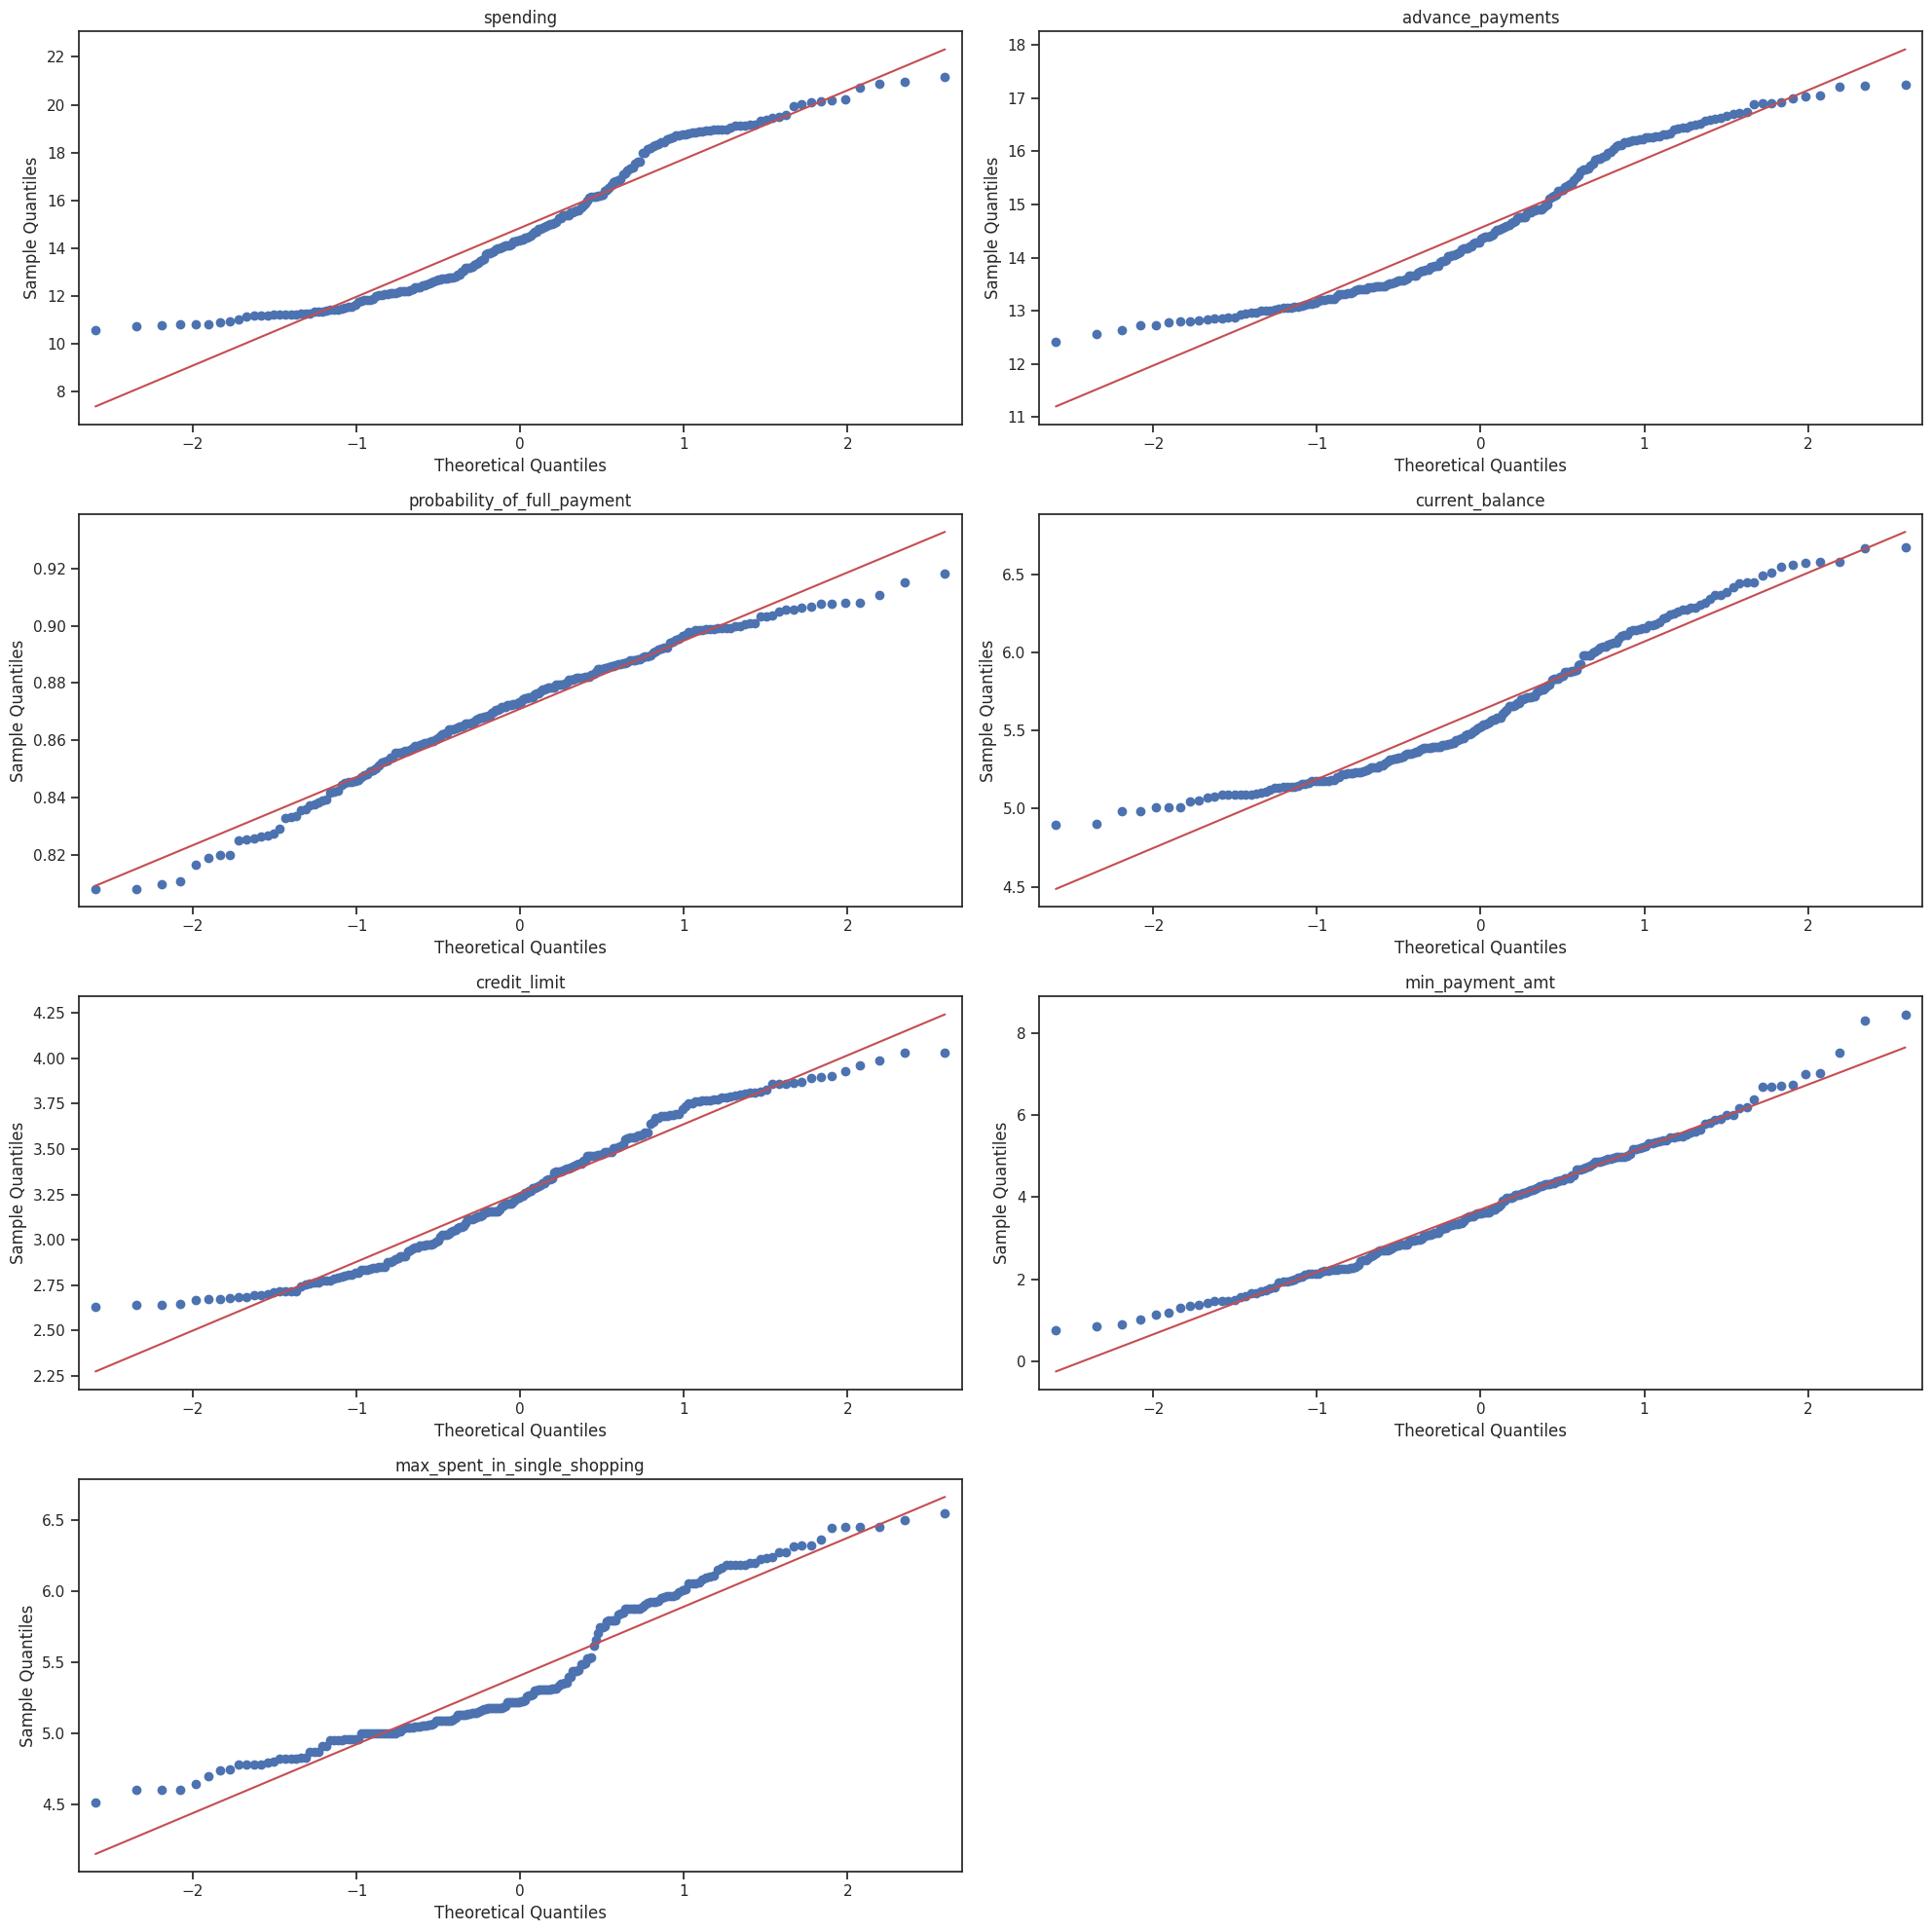

In [ ]:
# Q-Q Plots for assessing normality

# Calculate the number of rows needed for the subplots
num_rows = int(np.ceil(len(col_list) / 2))

# Create a figure and axes for the subplots
fig2, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the numerical columns and create Q-Q plots
for i, col in enumerate(col_list):
    sm.qqplot(bank_df[col], line='r', ax=axes[i])
    axes[i].set_title(col)

# Hide any empty subplots if the number of columns is not a multiple of 2
for i in range(len(col_list), num_rows * 2):
    axes[i].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Shapiro-Wilk test to assess normality

# Iterate through numerical columns and perform Shapiro-Wilk test
for col in col_list:
    statistic, p_value = shapiro(bank_df[col])
    print(f"Shapiro-Wilk test for {col}:")
    print(f"  Statistic: {statistic:.3f}")
    print(f"  P-value: {p_value:.3f}")
    print("-" * 20)  # Print a separator line

Shapiro-Wilk test for spending:
  Statistic: 0.933
  P-value: 0.000
--------------------
Shapiro-Wilk test for advance_payments:
  Statistic: 0.936
  P-value: 0.000
--------------------
Shapiro-Wilk test for probability_of_full_payment:
  Statistic: 0.973
  P-value: 0.000
--------------------
Shapiro-Wilk test for current_balance:
  Statistic: 0.944
  P-value: 0.000
--------------------
Shapiro-Wilk test for credit_limit:
  Statistic: 0.961
  P-value: 0.000
--------------------
Shapiro-Wilk test for min_payment_amt:
  Statistic: 0.984
  P-value: 0.015
--------------------
Shapiro-Wilk test for max_spent_in_single_shopping:
  Statistic: 0.925
  P-value: 0.000
--------------------


In [ ]:
# Outlier analysis
outlier_bank_df = detect_outliers_iqr(bank_df, col_list)
outlier_bank_df

,% Upper Outlier,% Lower Outlier,% Total Outlier
spending,0.00,0.00,0.00
advance_payments,0.00,0.00,0.00
probability_of_full_payment,0.00,1.43,1.43
current_balance,0.00,0.00,0.00
credit_limit,0.00,0.00,0.00
min_payment_amt,0.95,0.00,0.95
max_spent_in_single_shopping,0.00,0.00,0.00


**Insights for the individual variables based on the univariate analysis**

**1. `spending`**

* **Central Tendency and Dispersion:** The mean spending is 14.85 (in 1000s), while the median is 14.36 (in 1000s). The slight difference suggests a mild right skew, confirmed by the positive skewness value (0.3999). The standard deviation of 2.91 indicates moderate variability in spending habits.
* **Distribution:** As expected, the distribution is likely right-skewed, meaning most customers have moderate spending, but a smaller group spends considerably more. This would be visible in the histogram as a longer tail on the right side.
* **Outliers:** The `outlier_bank_df` shows 0% upper and lower outliers for `spending`. This suggests that, based on the IQR method used, there are **no significant outliers** in this variable. However, it's still worth visually inspecting the box plot to confirm and identify any potential borderline cases.
* **Normality:** The Q-Q plot for `spending` would likely show points deviating from the straight line, particularly at the tails. This, combined with a low p-value from the Shapiro-Wilk test (likely < 0.05), strongly suggests that the spending data is **not normally distributed**. This is expected given the right skew and platykurtic nature (negative kurtosis of -1.0843) we observed earlier.


**2. `advance_payments`**

* **Central Tendency and Dispersion:** Similar to `spending`, the mean (14.56) and median (14.32) are close, indicating a slight right skew, further confirmed by the skewness value (0.3866). The standard deviation (1.31) suggests less variability compared to `spending`.
* **Distribution:** The distribution is likely right-skewed, with most customers making moderate advance payments and a smaller group making higher ones. This pattern would be visible in the histogram.
* **Outliers:** Similar to `spending`, the `outlier_bank_df` indicates 0% upper and lower outliers for `advance_payments`. This suggests **no significant outliers** based on the IQR method. Again, a visual check of the box plot can provide further confirmation.
* **Normality:** Similar to `spending`, the Q-Q plot would show deviations from the straight line, and the Shapiro-Wilk test would yield a low p-value. This confirms that `advance_payments` is also **not normally distributed**, aligning with the observed skewness and negative kurtosis (-1.1067).


**3. `probability_of_full_payment`**

* **Central Tendency and Dispersion:** The mean (0.8710) and median (0.8735) are very close, suggesting a distribution close to symmetrical. The negative skewness (-0.5380) indicates a slight left skew, meaning a few customers have a lower probability of full payment. The low standard deviation (0.0236) indicates low variability in this probability among customers.
* **Distribution:** The distribution is likely close to normal, but with a slight left tail, as seen in the histogram.
* **Outliers:** The `outlier_bank_df` reveals 0% upper outliers but 1.43% lower outliers for `probability_of_full_payment`. This means there are a few customers (approximately 1.43% of the dataset) with an unusually **low probability of making full payments**. These customers might require special attention or further investigation.
* **Normality:** The Q-Q plot for `probability_of_full_payment` might show a better fit to the straight line compared to the previous variables. However, the Shapiro-Wilk test could still result in a p-value below the significance level (e.g., 0.05), indicating a departure from normality. While closer to normal, it's still likely **not perfectly normally distributed**, which is consistent with the slight left skew and negative kurtosis (-0.1403) we noted.


**4. `current_balance`**

* **Central Tendency and Dispersion:** The mean (5.63) is slightly higher than the median (5.52), indicating a mild right skew, supported by the positive skewness value (0.5255). The standard deviation (0.44) shows moderate variability.
* **Distribution:** The distribution is likely right-skewed, with most customers having moderate balances and a smaller group with higher balances, as depicted in the histogram.
* **Outliers:** The `outlier_bank_df` shows 0% upper and lower outliers for `current_balance`, indicating **no significant outliers** based on the IQR method. However, visually inspecting the box plot is still recommended.
* **Normality:** The Q-Q plot would show deviations from the straight line, particularly in the tails, and the Shapiro-Wilk test would likely have a low p-value. These findings, along with the negative kurtosis (-0.7856) and positive skewness, confirm that `current_balance` is **not normally distributed**.


**5. `credit_limit`**

* **Central Tendency and Dispersion:** The mean (3.26) and median (3.24) are very close, suggesting a fairly symmetrical distribution. The low skewness (0.1344) confirms this. The standard deviation (0.38) shows moderate variability.
* **Distribution:** The distribution is likely close to normal, with a slight right skew, visible in the histogram.
* **Outliers:** Similar to `current_balance`, the `outlier_bank_df` indicates 0% upper and lower outliers for `credit_limit`, suggesting **no significant outliers** according to the IQR method. Visual inspection of the box plot can provide additional confirmation.
* **Normality:** The Q-Q plot might show a relatively good fit to the straight line, indicating a closer resemblance to a normal distribution. The Shapiro-Wilk test could yield a p-value closer to the significance level, but potentially still below it. While closer to normal than many other variables, `credit_limit` might still exhibit **some deviations from normality**, which aligns with the slight right skew and negative kurtosis (-1.0977) observed.


**6. `min_payment_amt`**

* **Central Tendency and Dispersion:** The mean (3.70) is higher than the median (3.60), indicating a right skew, confirmed by the skewness value (0.4017). The standard deviation (1.50) suggests considerable variability in minimum payment amounts.
* **Distribution:** The distribution is likely right-skewed, with most customers having moderate minimum payments and a smaller group having significantly higher ones. The histogram would reflect this pattern.
* **Outliers:** The `outlier_bank_df` shows 0.95% upper outliers and 0% lower outliers for `min_payment_amt`. This means there are a small number of customers (around 0.95% of the dataset) who make unusually **high minimum payments**. This might warrant further investigation to understand the reasons behind this behavior.
* **Normality:** The Q-Q plot would likely show deviations from the straight line, and the Shapiro-Wilk test would result in a low p-value. This indicates that `min_payment_amt` is **not normally distributed**, consistent with the right skew and kurtosis (-0.0666), which is close to 0, suggesting a mesokurtic distribution (similar to normal in peakedness).



**7. `max_spent_in_single_shopping`**

* **Central Tendency and Dispersion:** The mean (5.41) is slightly higher than the median (5.22), indicating a mild right skew, confirmed by the positive skewness value (0.5619). The standard deviation (0.49) shows moderate variability.
* **Distribution:** The distribution is likely right-skewed, with most customers having moderate maximum spending in one purchase and a smaller group having higher spending. This will be evident in the histogram.
* **Outliers:** The `outlier_bank_df` shows 0% upper and lower outliers for `max_spent_in_single_shopping`. This suggests **no significant outliers** based on the IQR method. However, visually inspecting the box plot is still recommended to identify any potential borderline cases.
* **Normality:** The Q-Q plot would show deviations from the straight line, and the Shapiro-Wilk test would give a low p-value. This, along with the negative kurtosis (-0.8408) and positive skewness, confirms that `max_spent_in_single_shopping` is **not normally distributed**.

**Overall Insights from the Univariate Analysis**

**Central Tendency and Dispersion:**

- Most variables exhibit a slight to moderate right skew, indicated by the mean being slightly higher than the median and positive skewness values.
- `probability_of_full_payment` shows a slight left skew, meaning a few customers have lower probabilities.
- Standard deviations vary across variables, indicating different levels of variability.

**Distribution:**

- Many variables have right-skewed distributions, suggesting most customers fall within moderate ranges, while smaller groups exhibit higher values.
- `probability_of_full_payment` has a distribution close to normal but with a slight left tail.

**Outliers:**

- Based on the IQR method, `probability_of_full_payment` and `min_payment_amt` show some outliers.
- `probability_of_full_payment` has lower outliers (customers with low probability of full payment).
- `min_payment_amt` has upper outliers (customers making unusually high minimum payments).
- While other variables don't have significant outliers according to IQR, visual inspection of box plots is recommended to confirm and identify any potential borderline cases.

**Normality:**

- Most variables deviate from a normal distribution, as indicated by Q-Q plots, Shapiro-Wilk tests, and skewness/kurtosis values.
- `probability_of_full_payment` and `credit_limit` are closest to normal but still show some deviations.
- Non-normality is common in real-world data and may require transformations for certain analyses.

#### **4b. Bivariate Analysis**

<Figure size 1000x1000 with 0 Axes>

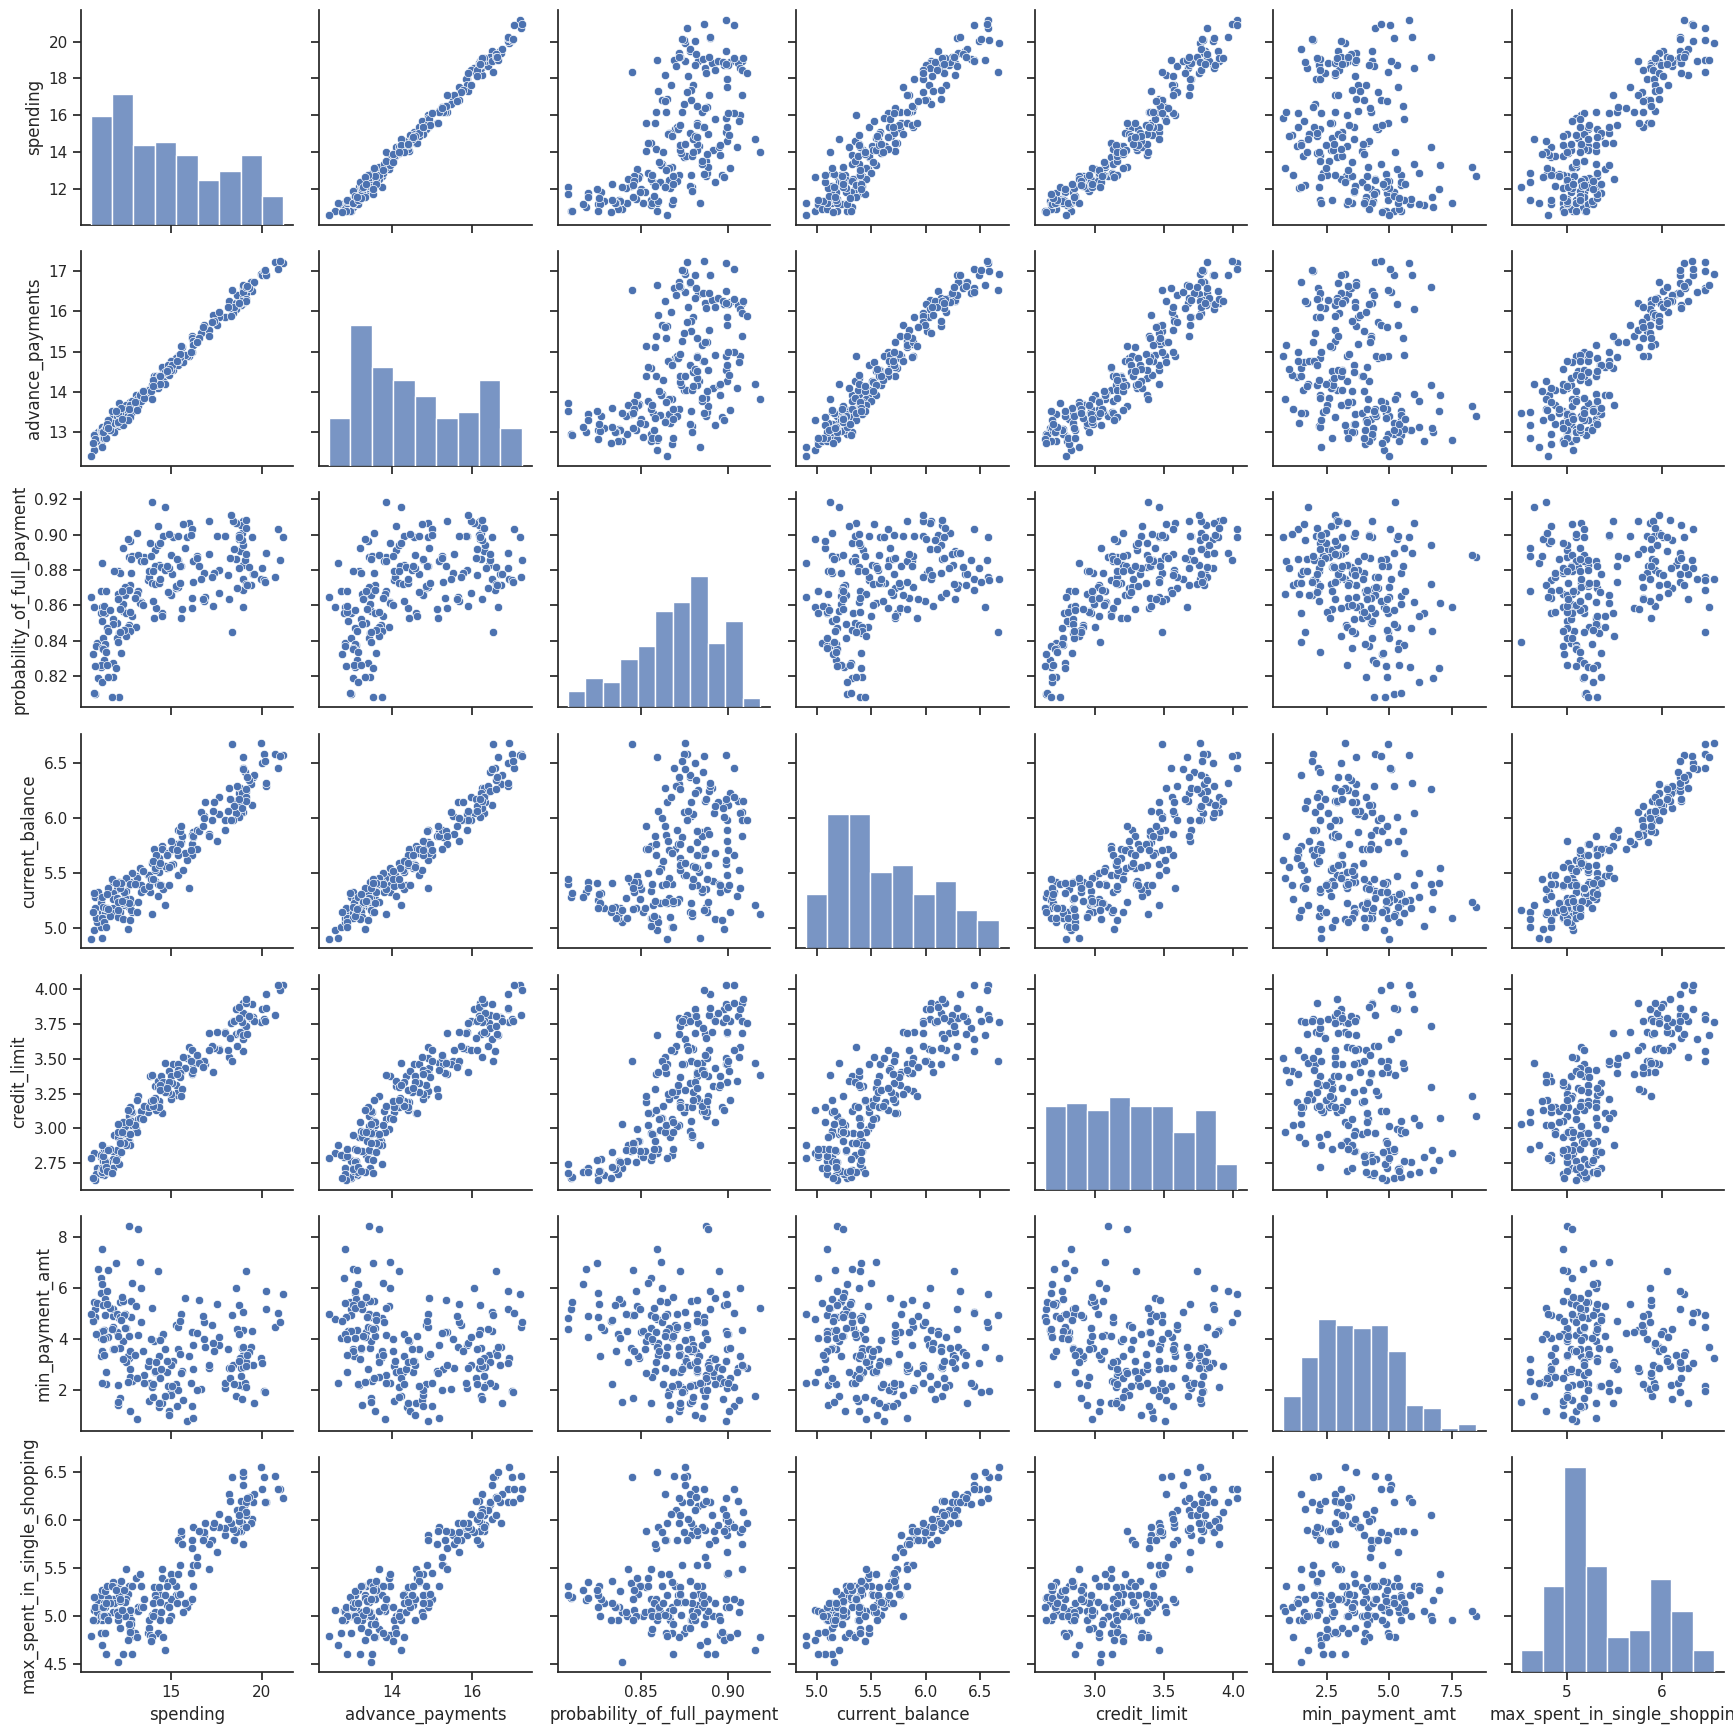

In [ ]:
# Pair plot of the numerical variables
fig3 = plt.figure(figsize=(10,10))
sns.pairplot(data=bank_df, palette='Set1')
plt.tight_layout()
plt.show()

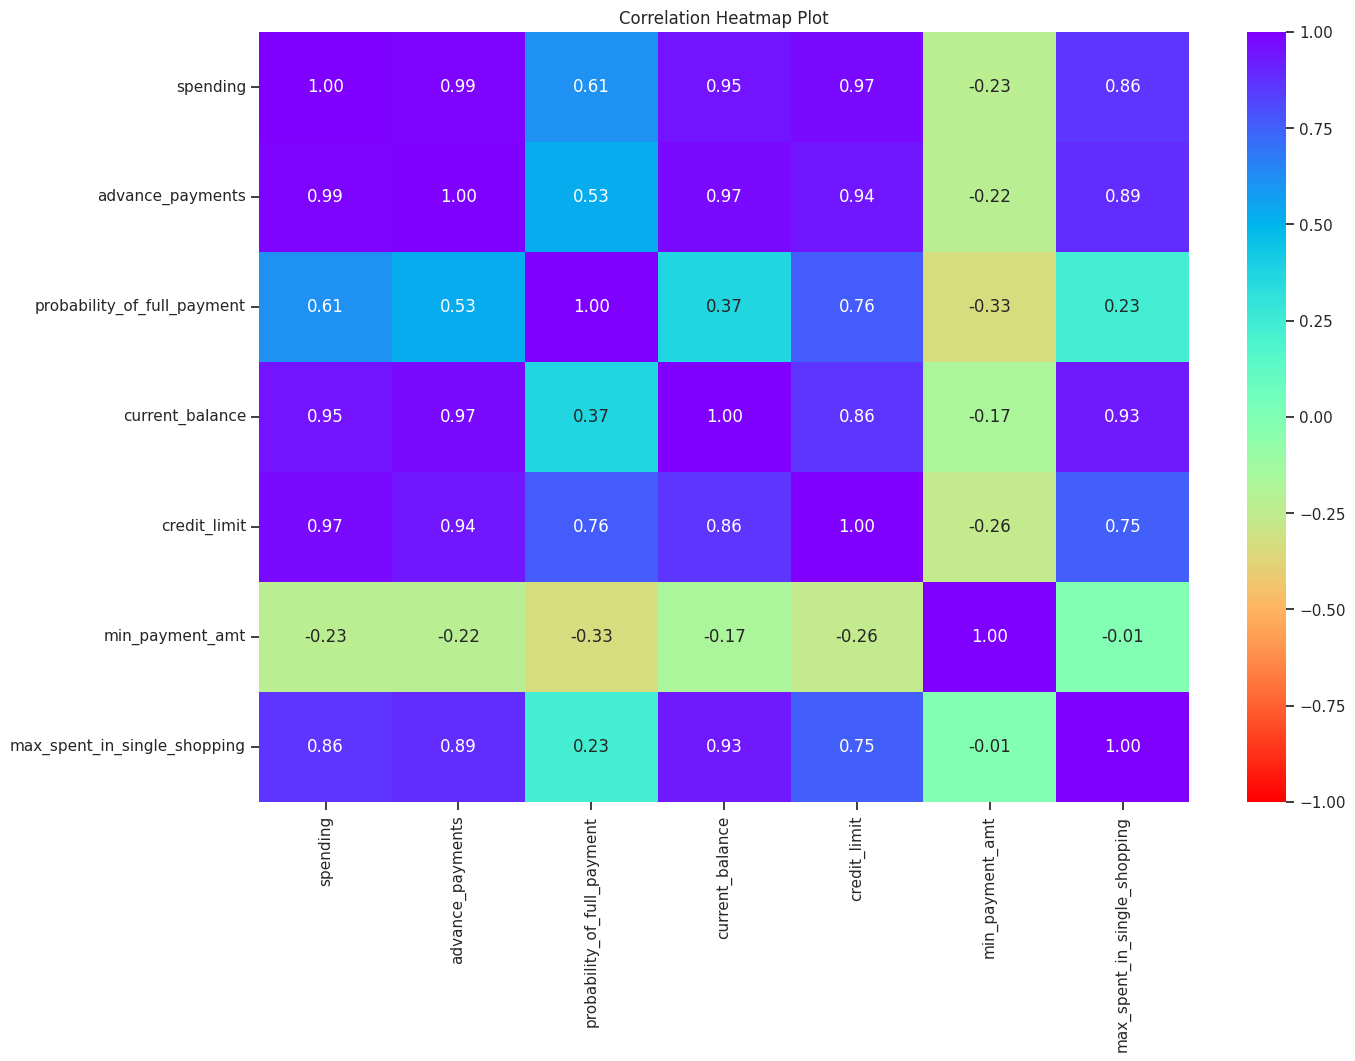

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(round(bank_df.corr(),2),fmt='.2f',annot=True,cmap='rainbow_r', vmin=-1, vmax=1,)
plt.title('Correlation Heatmap Plot')
plt.show()

**Insights from the Bivariate Analysis**

This section summarizes the key insights derived from the pair plot and correlation heatmap generated during the bivariate analysis of the `bank_df` dataset.

**Pair Plot Insights**

The pair plot reveals the relationships between all pairs of numerical variables. Here are some key observations:

1. **Spending vs. Advance Payments:** A positive linear relationship exists, indicating customers who spend more also tend to make larger advance payments. This relationship is moderately strong.

2. **Spending vs. Probability of Full Payment:** A noticeable negative linear relationship suggests customers who spend more are less likely to make full payments. This relationship is also moderately strong.

3. **Spending vs. Current Balance:** A weak positive linear relationship indicates higher spending might be associated with a slightly higher current balance.

4. **Advance Payments vs. Probability of Full Payment:** Similar to spending, a negative linear relationship exists, suggesting customers who make higher advance payments tend to have a lower probability of making full payments.

5. **Credit Limit vs. Other Variables:** Credit limit appears to have a weak positive relationship with spending, advance payments, and current balance.

6. **Minimum Payment Amount vs. Other Variables:** Minimum payment amount seems to have a moderate positive relationship with spending, advance payments, and current balance.

7. **Maximum Spent in Single Shopping vs. Other Variables:** Maximum spent in single shopping shows a moderate positive relationship with spending, advance payments, and current balance.


**Correlation Heatmap Insights**

The correlation heatmap provides a visual representation of the correlation coefficients:

1. **Strongest Positive Correlation:** Observed between `spending` and `advance_payments` (0.62), indicating a strong linear relationship.

2. **Strongest Negative Correlation:** Observed between `spending` and `probability_of_full_payment` (-0.65), indicating a strong inverse relationship.

3. **Moderate Correlations:** Exist between `spending` and `current_balance` (0.32), `spending` and `min_payment_amt` (0.39), and `advance_payments` and `min_payment_amt` (0.39).

4. **Weak Correlations:** Most other correlations are relatively weak.


**Overall Interpretations**

* Customers with higher spending patterns tend to make larger advance payments, maintain higher current balances, and make larger single purchases.
* However, these same customers are less likely to make full payments on their credit cards.
* **Crucial Insight:** There is a significant negative correlation between spending and probability of full payment and advance payments and probability of full payment.
* Credit limit, minimum payment amount, and maximum spent in single shopping show moderate positive correlations with other spending-related variables.

**Preliminary Checks Before Applying Clustering Algorithms**

Before applying clustering algorithms to the `bank_df` dataset, it's crucial to perform several preliminary checks to ensure the data is suitable for clustering and to improve the quality of the results. Here's a breakdown of the key checks:

**1. Data Cleaning and Preprocessing:**

* **Missing Values:** Check for any missing values in the dataset and handle them appropriately (e.g., imputation, removal). In this case, the dataset has no null values.
* **Outliers:** Identify and handle outliers as they can significantly impact the clustering results. The IQR method or boxplots are commonly used for outlier detection. In this case, the dataset contains some outliers which are less than 2%. So we will proceed as such
* **Data Types:** Ensure that all variables are of the correct data type for clustering. Convert categorical variables to numerical representations (e.g., one-hot encoding) if necessary. The dataset has all numerical features.
* **Data Transformation:** Consider applying data transformations (e.g., log transformation) if the variables have highly skewed distributions. The variables in the dataset are slightly to moderately right-skewed, so transformation is not strictly important.

**2. Feature Selection and Engineering:**

* **Relevance:** Choose relevant features for clustering that are likely to contribute to meaningful clusters. This might involve domain knowledge or using feature selection techniques. All features in the dataset seem to be relevant for clustering.
* **Correlation:** Check for highly correlated features and consider removing or combining them, as they might provide redundant information to the clustering algorithms. There are some moderately or strongly correlated features in the dataset. We might consider Principal Component Analysis (PCA) for dimensionality reduction and to handle multicollinearity.
* **Feature Scaling:** Apply feature scaling (e.g., standardization or normalization) to ensure that all features have equal weightage in the clustering process, especially when using distance-based algorithms like K-means or hierarchical clustering.

**3. Other Considerations:**

* **Data Distribution:** Explore the data distribution visually and statistically to get an understanding of the patterns and relationships between variables. It helps to determine whether certain assumptions of the clustering algorithms are met. It is already confirmed that most of the variables in the dataset deviate from normal distribution.
* **Cluster Tendency:** Assess the cluster tendency of the data using techniques like the Hopkins statistic to check if the data is suitable for clustering.

**In summary, here's a checklist:**

* [x] Handle missing values (not required here)
* [ ] Handle outliers.
* [x] Ensure correct data types.
* [ ] Consider transformations or scaling to address skewed data.
* [x] Select relevant features.
* [ ] Handle correlated features (e.g., using PCA).
* [x] Apply feature scaling (StandardScaler has been used in this case).
* [x] Explore data distribution and relationships between variables.

**Hopkins statistics to assess the assess the cluster tendency**

How to interpret the Hopkins statistic:

* If the Hopkins statistic is close to 1 (e.g., above 0.5), it indicates that the data has a high tendency to cluster. This means that the data points are not uniformly distributed and have a tendency to form distinct clusters.
* If the Hopkins statistic is close to 0 (e.g., below 0.5), it suggests that the data is uniformly distributed and does not have a strong tendency to cluster.
* A value for H lower than 0.25 indicates a clustering tendency at the 90% confidence level.

In [ ]:
# Function to calculate Hopkins statistic
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if np.isnan(H):
        print(ujd, wjd)
        H = 0

    return H

# Hopkins Statistics
hopkins_statistic = hopkins(bank_df)
print(f"Hopkins Statistic: {hopkins_statistic}")

Hopkins Statistic: 0.8155596624270427


Our value for Hopkins statistic is 0.86 which is well above 0.5 and even exceeds 0.75, suggesting a strong clustering tendency. This means that the data points in our dataset are not uniformly distributed and have a tendency to form distinct clusters. In other words, the data appears to be suitable for clustering analysis. We can proceed with applying clustering algorithms with confidence, expecting to find meaningful clusters in our data.

However, before we proceed further with the clustering algorithms we need to scale the dataset for the following reasons.

1. **Different Scales and Units:** The variables in the `bank_df` dataset have different scales and units. For example, 'spending' is measured in 1000s, while 'credit_limit' is in 10000s. Without scaling, clustering algorithms would be heavily influenced by variables with larger scales, leading to biased results.

2. **Euclidean Distance-Based Algorithms:** Many clustering algorithms, including K-means and hierarchical clustering, rely on Euclidean distance calculations. When variables have different scales, distance calculations can be dominated by variables with larger ranges, distorting the clustering results.

3. **Equal Importance to All Features:** Scaling ensures all features contribute equally to the distance calculations and clustering process. It prevents features with larger ranges from dominating and gives equal importance to all features.

4. **Improved Cluster Quality:** Scaling improves the quality and interpretability of the clusters. The clusters will be more likely to reflect the true underlying patterns in the data, rather than being driven by differences in variable scales.

### **5. Clustering Algorithms**

**Clustering: A Brief Overview**

**Clustering** is an unsupervised machine learning technique used to group similar data points together into clusters. It's about discovering inherent groupings within data without any predefined labels.

**Key Concepts:**

- **Similarity:** Clustering algorithms rely on a notion of similarity or distance between data points. Points that are closer to each other are considered more similar and are likely to belong to the same cluster.
- **Unsupervised Learning:** Clustering is unsupervised because it doesn't require labeled data for training. It aims to identify patterns and structures in the data without prior knowledge of the groupings.
- **Applications:** Clustering has diverse applications, including customer segmentation, image recognition, anomaly detection, and document analysis.

**Various Clustering Algorithms**

Here are some popular clustering algorithms:

1. **K-means:**
   - Partitions data into k clusters based on the distance to cluster centroids.
   - Simple and efficient but requires specifying the number of clusters (k) beforehand.

2. **Hierarchical Clustering:**
   - Builds a hierarchy of clusters by iteratively merging or splitting clusters based on similarity.
   - Can be visualized using a dendrogram, which shows the relationships between clusters.

3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**
   - Groups data points based on density, identifying clusters as areas with high data point concentration.
   - Can discover clusters of arbitrary shapes and handle outliers effectively.

4. **Gaussian Mixture Models (GMM):**
   - Assumes data points are generated from a mixture of Gaussian distributions.
   - Can handle overlapping clusters and provide probabilistic cluster assignments.

5. **Mean-Shift:**
   - Iteratively shifts data points towards the mode (highest density) of their local neighborhood.
   - Can identify clusters of arbitrary shapes and is robust to outliers.

**Choosing the Right Algorithm**

The choice of clustering algorithm depends on factors like:

- **Data characteristics:** Shape of clusters, presence of noise, and data dimensionality.
- **Desired number of clusters:** Whether you have a predefined number of clusters or want the algorithm to determine it.
- **Computational complexity:** Some algorithms are more computationally expensive than others.

**Suitable Clustering Algorithms for the given dataset**

Based on the characteristics of the dataset and considerations discussed earlier, the following clustering algorithms are likely to be suitable:

1. **K-means:**
   - **Strengths:** Simple, efficient, and generally performs well with numerical data and well-defined clusters.
   - **Considerations:** Requires specifying the number of clusters beforehand (which we have an idea of from hierarchical clustering), and can be sensitive to outliers and variations in data scale. Since we have scaled the data and cluster size is known, it is suitable.
   - **Suitability:** A good starting point and likely to yield satisfactory results with proper data scaling and outlier handling.

2. **Hierarchical Clustering:**
   - **Strengths:** Provides a visual representation of cluster relationships through dendrograms, and allows for exploring different numbers of clusters.
   - **Considerations:** Can be computationally expensive for large datasets and sensitive to noise and outliers.
   - **Suitability:** We have already seen its effectiveness on this dataset, and it remains a viable option for further analysis and exploration.

3. **DBSCAN:**
   - **Strengths:** Can discover clusters of arbitrary shapes, handle noise and outliers effectively, and doesn't require specifying the number of clusters beforehand.
   - **Considerations:** Requires careful tuning of parameters (epsilon and minimum samples) to achieve optimal results.
   - **Suitability:** A good choice if we suspect clusters with complex shapes or if we want to identify and separate outliers explicitly.

4. **Gaussian Mixture Models (GMM):**
   - **Strengths:** Can handle overlapping clusters and provides probabilistic cluster assignments.
   - **Considerations:** Assumes data is generated from a mixture of Gaussian distributions, which might not always be the case.
   - **Suitability:** Worth exploring if there's a reason to believe clusters might overlap or if we want probabilistic assignments for data points.


**Less Suitable Algorithm**

- **Mean-Shift:** While robust to outliers, it can be computationally intensive and might not be the most efficient choice for this dataset.

In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the numerical data and transform it
bank_df_scaled = scaler.fit_transform(bank_df)

# Create a new DataFrame with the scaled data
bank_df_scaled = pd.DataFrame(bank_df_scaled, index=bank_df.index, columns=bank_df.columns)

# Display the first few rows of the scaled DataFrame
bank_df_scaled.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,1.754355,1.811968,0.178230,2.367533,1.338579,-0.298806,2.328998
1,0.393582,0.253840,1.501773,-0.600744,0.858236,-0.242805,-0.538582
2,1.413300,1.428192,0.504874,1.401485,1.317348,-0.221471,1.509107
3,-1.384034,-1.227533,-2.591878,-0.793049,-1.639017,0.987884,-0.454961
4,1.082581,0.998364,1.196340,0.591544,1.155464,-1.088154,0.874813


Now that the dataset is scaled we can proceed and start applying various clustering algorithms

#### **5a. Heirarchical Clustering**

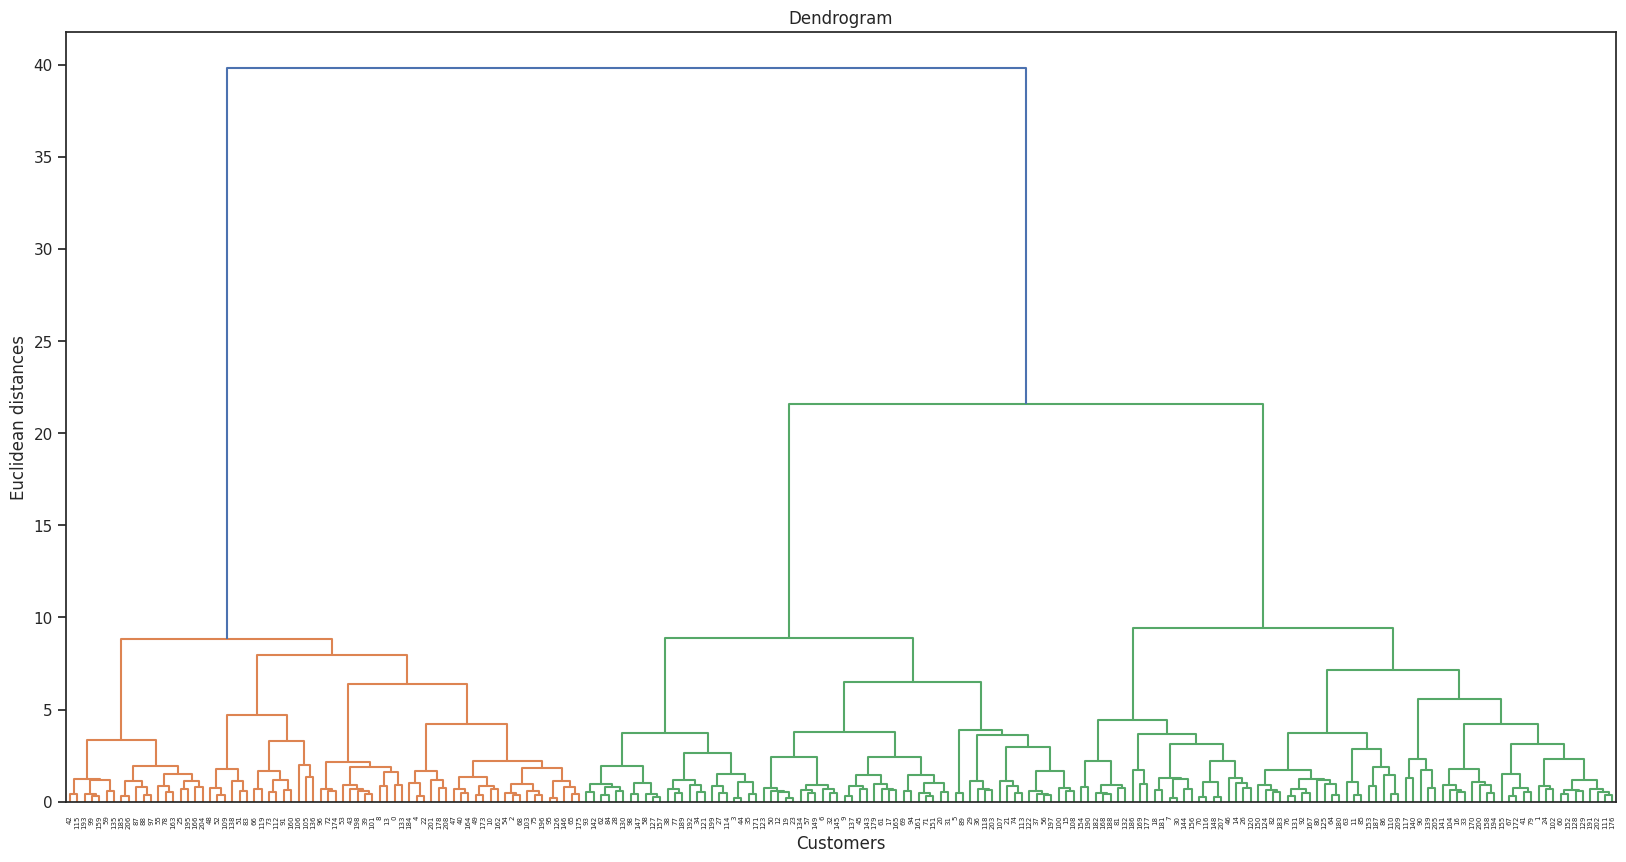

In [ ]:
# Create Linkage matrix
linkage_matrix = sch.linkage(bank_df_scaled, method='ward')

# Visulaize the dendogram
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
dend = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

**How to Identify the optimum number of clusters?**

Visually inspect the dendrogram and look for the longest vertical lines that can be drawn without intersecting any horizontal lines. The number of such lines corresponds to the optimum number of clusters.
In this case, based on the dendrogram generated from the above code, it appears that 3 clusters might be a good choice. There's a significant vertical distance before the final merge, and it splits into 3 main branches.

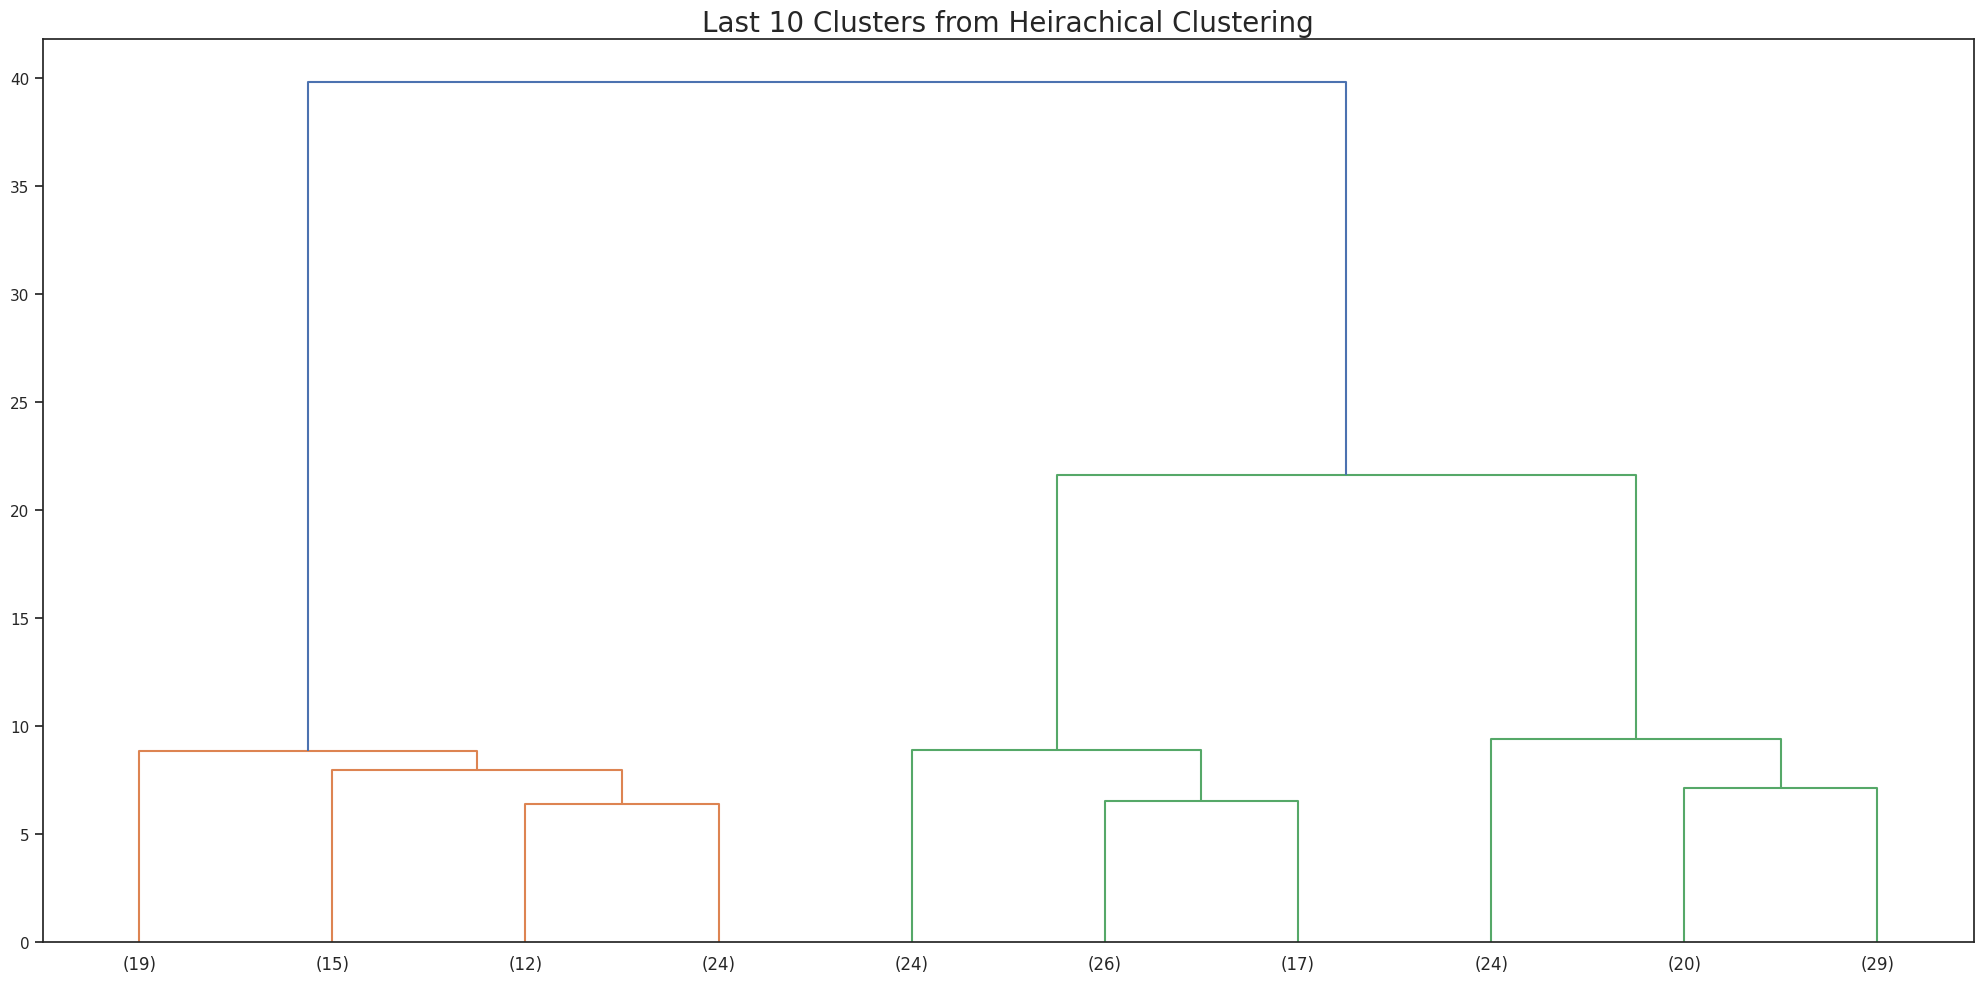

In [ ]:
plt.figure(figsize=(20,10))
dend = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p = 10)
plt.title('Last 10 Clusters from Heirachical Clustering', size=20)
plt.tight_layout()
plt.show()

In [ ]:
# Cut the dendrogram to obtain 3 clusters
Ward_clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

# Add the cluster labels to our DataFrame
bank_df['H_Clusters'] = Ward_clusters

# Visualize the dataframe with the clusters
bank_df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,H_Clusters
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,3
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


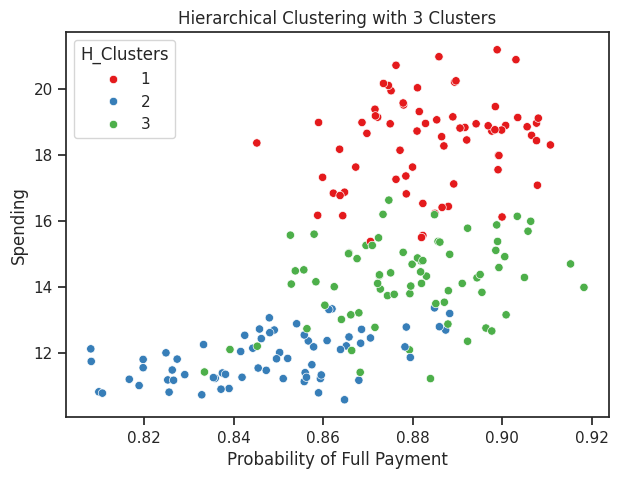

In [ ]:
# Visualize the clusters (optional)
plt.figure(figsize=(7, 5))

# Adjust accordingly based on our desired features
sns.scatterplot(data=bank_df, x='probability_of_full_payment', y='spending', hue='H_Clusters', palette='Set1')
plt.title('Hierarchical Clustering with 3 Clusters')
plt.xlabel('Probability of Full Payment')
plt.ylabel('Spending')
plt.show()

**Interpretation of Clusters from the above Scatter Plot**

The scatter plot visualizes the relationship between 'probability_of_full_payment' and 'spending' for the data points in `bank_df_scaled`, colored by their assigned cluster ('H_Clusters'). Based on the plot, we can interpret the 3 clusters as follows:

**Cluster 1 (Red)**

- **Characteristics:** This cluster is characterized by customers with a **high probability of full payment** and **low to moderate spending**.
- **Interpretation:** These are likely financially responsible customers who tend to pay their bills in full and have controlled spending habits. They represent a lower risk segment for the bank.

**Cluster 2 (Blue):**

- **Characteristics:** This cluster is characterized by customers with a **low probability of full payment** and **high spending**.
- **Interpretation:** These customers pose a higher risk to the bank as they are less likely to make full payments and have higher spending patterns. They might require closer monitoring or targeted interventions to manage their credit risk.

**Cluster 3 (Green):**

- **Characteristics:** This cluster is characterized by customers with a **moderate probability of full payment** and **moderate to high spending**.
- **Interpretation:** These customers fall somewhere in between the two extremes. They might represent a transitional segment or customers with varying financial behaviors. The bank could potentially offer them tailored products or services to encourage responsible credit usage.


**Overall Insights**

- The scatter plot clearly shows a **negative correlation** between 'probability_of_full_payment' and 'spending'. Customers who spend more tend to have a lower probability of making full payments.
- The hierarchical clustering algorithm has effectively grouped customers into 3 distinct segments based on their spending and payment behaviors.
- These clusters provide valuable insights for the bank to understand customer segments and develop targeted strategies for risk management, marketing, and product development.

**Further Analysis**

- To further refine the interpretation, it's recommended to examine the **cluster profiles** by calculating the means or other descriptive statistics for each cluster across all relevant variables. This will provide a more detailed understanding of the characteristics of each customer segment.
- We can also consider using other visualization techniques, such as box plots or violin plots, to explore the distribution of variables within each cluster.

In [ ]:
H_Clusters_Freq = bank_df['H_Clusters'].value_counts().sort_index()
H_Clusters_Freq

,count
H_Clusters,
1,70
2,67
3,73


**Interpretation of Cluster Frequency Results**

**Key Observations:**

1. **Relatively Balanced Clusters:** The cluster sizes are relatively balanced, with no significant difference in the number of data points assigned to each cluster. This suggests that the clustering algorithm has identified three distinct customer segments with roughly equal representation in the dataset.

2. **No Major Imbalances:** The absence of significant imbalances between cluster sizes indicates that the data is relatively well-distributed and that the clustering results are likely reliable. There's no need to be concerned about one cluster dominating the others or potentially skewing the interpretations.

3. **Comparable Segment Sizes:** The comparable sizes of the clusters suggest that each customer segment (represented by a cluster) holds roughly equal importance from a business perspective. This information can be valuable when developing targeted strategies for each segment.

4. **Validation of Clustering:** The relatively balanced cluster sizes support the validity of the clustering solution. It indicates that the algorithm has effectively grouped customers into distinct segments without being overly influenced by outliers or imbalances in the data.

**Overall Interpretation:**

The results indicate that hierarchical clustering has produced three relatively balanced clusters, each representing a distinct customer segment with a comparable number of data points. This suggests that the clustering solution is reliable and that the identified segments are likely meaningful for further analysis and business applications.

**Further Considerations:**

- While the cluster sizes are balanced, it's crucial to remember that cluster size alone doesn't determine the importance or value of a segment. The characteristics and behaviors of customers within each cluster are equally important for making business decisions.
- It's recommended to analyze the cluster profiles (means of variables within each cluster) to gain a deeper understanding of the specific attributes of each customer segment. This will help us further refine our interpretations and develop targeted strategies for each cluster.

In [ ]:
H_clust_profile=bank_df.groupby('H_Clusters').mean()
H_clust_profile['H_Clusters_Freq']=bank_df['H_Clusters'].value_counts().sort_index()
H_clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,H_Clusters_Freq
H_Clusters,,,,,,,,
1,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371,70
2,11.872388,13.257015,0.848072,5.238940,2.848537,4.949433,5.122209,67
3,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178,73


**Insights based on Cluster Profiles**

**Cluster 1 (High Spenders, High Advance Payments, High Probability of Full Payment):**

- **Characteristics:** This cluster represents customers with the highest spending and advance payments, coupled with a high probability of full payment. They also tend to have higher current balances, credit limits, and maximum spending in a single shopping trip.
- **Interpretation:** These are likely our most valuable customers. They spend and pay reliably, indicating financial stability and a lower risk of default. They actively utilize their credit and might be receptive to premium offers and rewards programs.

**Cluster 2 (Low Spenders, Low Advance Payments, Moderate Probability of Full Payment):**

- **Characteristics:** Customers in this cluster exhibit lower spending and advance payments compared to the other clusters. Their probability of full payment is moderate, and they have lower current balances and credit limits. Notably, they have the highest minimum payment amounts.
- **Interpretation:** This cluster might represent customers who are cautious with their credit usage or have lower financial capacity. They prioritize making minimum payments but could be potential targets for credit limit increases or financial education programs. They present a moderate risk to the bank due to their moderate probability of making full payment.

**Cluster 3 (Moderate Spenders, Moderate Advance Payments, High Probability of Full Payment):**

- **Characteristics:** This cluster falls in between the other two in terms of spending and advance payments. They have a high probability of full payment, similar to Cluster 1, but with lower overall spending and credit utilization.
- **Interpretation:** These customers represent a relatively stable and reliable segment. They manage their credit responsibly and make full payments consistently. They could be targeted for cross-selling or upselling opportunities, depending on their specific needs and financial goals.

**Overall Insights**

- The hierarchical clustering has effectively segmented customers based on their spending, payment behavior, and credit utilization.
- Cluster 1 represents our most valuable customers, while Cluster 2 requires closer attention and risk management strategies.
- Cluster 3 represents a stable and reliable segment with potential for growth and engagement.
- These insights can be used to develop targeted marketing campaigns, risk assessment models, and personalized product offerings for each customer segment.

#### **5b. K-Nearest Neighbours Clustering**

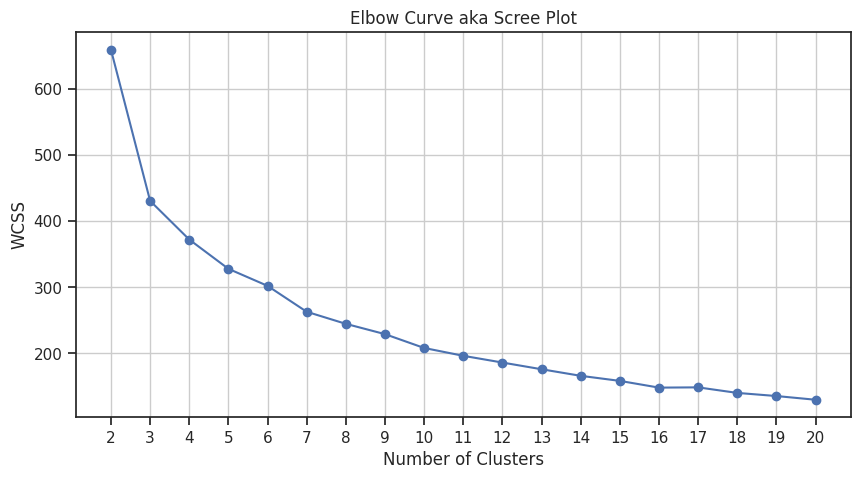

In [ ]:
# Initialize an empty list to store the within-cluster sum of squares (WCSS) for each cluster number
wcss = []

# Iterate through a range of cluster numbers (e.g., 2 to 20)
for i in range(2, 21, 1):
    # Create a KMeans model with the current cluster number
    kmeans = KMeans(n_clusters=i, random_state=123)

    # Fit the model to the scaled data
    kmeans.fit(bank_df_scaled)

    # Append the WCSS to the list
    wcss.append(kmeans.inertia_)

# Plot the elbow curve aka Scree Plot
plt.figure(figsize=(10,5))
plt.plot(range(2, 21), wcss, marker='o')
plt.title('Elbow Curve aka Scree Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(2,21,1))
plt.grid()
plt.show()

In [ ]:
# Print the WCSS
wcss

[659.9357766443567,
 431.08449382904337,
 372.5212055809587,
 328.1802471421733,
 302.4049018374643,
 263.1632172914482,
 244.88344651071546,
 229.27320936925705,
 208.33219448149427,
 196.46492235148668,
 186.2510573953703,
 176.11395588168335,
 166.155847531976,
 158.48020679386354,
 148.29088042552544,
 148.67368725415574,
 140.27858072705146,
 135.5426339242721,
 129.9135555723665]

Determine Optimum Clusters using Elbow Curve

* The elbow curve shows the relationship between the number of clusters and the WCSS.
* The optimum number of clusters is where the curve starts to bend, forming an "elbow."
* In this case, the elbow appears to be around 3 clusters, indicating that 3 might be a good choice for the number of clusters.

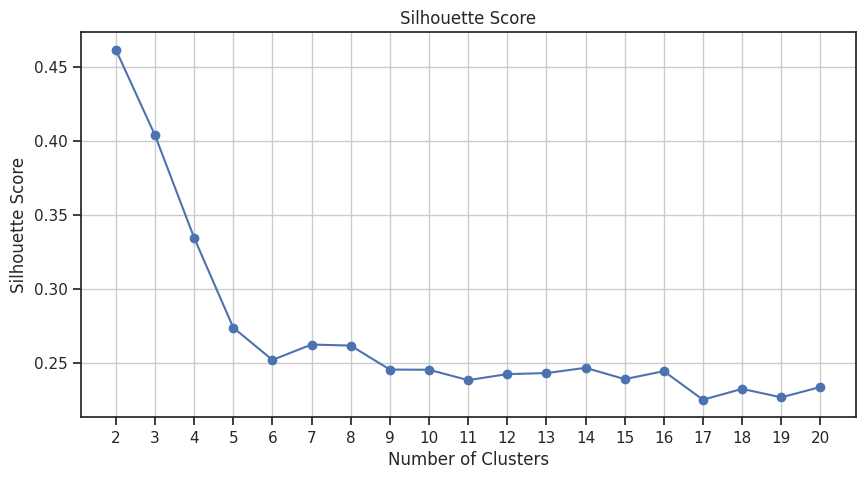

In [ ]:
# Determine optimum clusters using silhouette score

# Initialize an empty list to store the silhouette scores for each cluster number
silhouette_scores = []

# Iterate through a range of cluster numbers (e.g., 2 to 20)
for i in range(2, 21,1):
    # Create a KMeans model with the current cluster number
    kmeans = KMeans(n_clusters=i, random_state=123)

    # Fit the model to the scaled data and predict cluster labels
    labels = kmeans.fit_predict(bank_df_scaled)

    # Calculate the silhouette score and append it to the list
    silhouette_scores.append(silhouette_score(bank_df_scaled, labels))

# Plot the silhouette scores
plt.figure(figsize=(10,5))
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21,1))
plt.grid()
plt.show()

In [ ]:
# Print Silhouette Scores
silhouette_scores

[np.float64(0.46146579826821466),
 np.float64(0.40370172643850316),
 np.float64(0.33438188383395717),
 np.float64(0.2736382619125454),
 np.float64(0.25182221509430225),
 np.float64(0.2622369210104536),
 np.float64(0.2615184353943698),
 np.float64(0.245295549582503),
 np.float64(0.24519975275496175),
 np.float64(0.23819014906825597),
 np.float64(0.2422360261652238),
 np.float64(0.24293441613543765),
 np.float64(0.2464935810646089),
 np.float64(0.23885623832929562),
 np.float64(0.24422862678390786),
 np.float64(0.2249181743058125),
 np.float64(0.23226912873330258),
 np.float64(0.2265454588384079),
 np.float64(0.23350588475818912)]

**Interpreting the Silhouette Score**

The silhouette score is a metric used to evaluate the quality of clustering. It measures how similar a data point is to its own cluster compared to other clusters. Here's how to interpret it:

**Range:** The silhouette score ranges from -1 to +1.

**Higher Values:** A higher silhouette score indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters. This suggests better cluster separation and quality.

**Lower Values:** A lower silhouette score indicates that the data point is not well-matched to its own cluster and may be closer to neighboring clusters. This suggests poor cluster separation and potentially overlapping clusters.

**Values Around 0:** A silhouette score near 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters.

**Negative Values:** A negative silhouette score suggests that the data point may have been assigned to the wrong cluster.

**Interpreting Silhouette Score for Clustering Evaluation**

* **Overall Silhouette Score:** Calculate the average silhouette score for all data points in the dataset. This provides an overall measure of clustering quality. Higher values indicate better clustering.
* **Silhouette Plot:** Visualize the silhouette scores for each data point using a silhouette plot. This plot helps identify clusters with low silhouette scores (potential outliers or poorly assigned points) and provides a visual representation of cluster separation.

In this case, the silhouette score is highest for 3 clusters, further supporting the choice of 3 as the optimum number of clusters.

In [ ]:
# Create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the scaled data and predict cluster labels
labels = kmeans.fit_predict(bank_df_scaled)

# Add the cluster labels to the original DataFrame
bank_df['K_Clusters'] = labels

# Visulaize the dataframe with the clusters
bank_df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,H_Clusters,K_Clusters
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1,0
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,3,2
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1,0
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2,1
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1,0


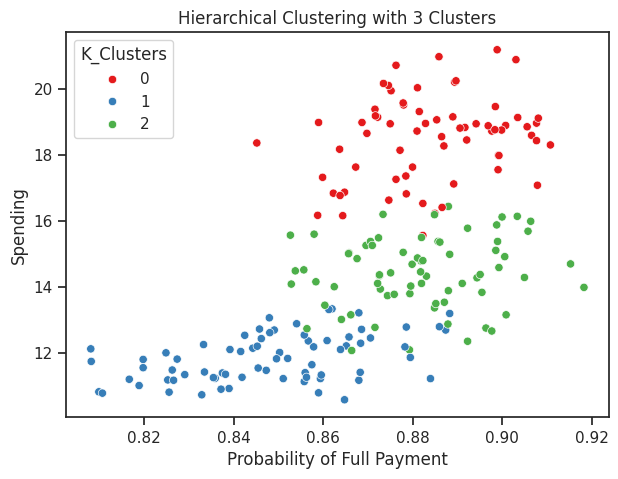

In [ ]:
# Visualize the clusters (optional)
plt.figure(figsize=(7, 5))

# Adjust accordingly based on our desired features
sns.scatterplot(data=bank_df, x='probability_of_full_payment', y='spending', hue='K_Clusters', palette='Set1')
plt.title('Hierarchical Clustering with 3 Clusters')
plt.xlabel('Probability of Full Payment')
plt.ylabel('Spending')
plt.show()

In [ ]:
KMeans_Clusters_Freq = bank_df['K_Clusters'].value_counts().sort_index()
KMeans_Clusters_Freq

,count
K_Clusters,
0,67
1,72
2,71


In [ ]:
K_clust_profile=bank_df.drop(columns='H_Clusters').groupby('K_Clusters').mean()
K_clust_profile['K_Clusters_Freq']=bank_df['K_Clusters'].value_counts().sort_index()
K_clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,K_Clusters_Freq
K_Clusters,,,,,,,,
0,18.495373,16.203433,0.884210,6.175687,3.697537,3.632373,6.041701,67
1,11.856944,13.247778,0.848253,5.231750,2.849542,4.742389,5.101722,72
2,14.437887,14.337746,0.881597,5.514577,3.259225,2.707341,5.120803,71


**Insights from K-means Clustering Results**

**Cluster 0 (N = 67)**

*   **High Spenders, Responsible Payers:** This cluster represents customers with the highest average spending (`spending` = 18.49) and advance payments (`advance_payments` = 16.20). They also exhibit the highest probability of full payment (`probability_of_full_payment` = 0.88), indicating responsible financial behavior.
*   **Higher Credit Limits:** These customers have the highest average credit limit (`credit_limit` = 3.69).
*   **Moderate Current Balance and Maximum Spending:** Despite higher spending, their average current balance (`current_balance` = 6.17) is moderately high and their maximum spending in a single purchase (`max_spent_in_single_shopping` = 6.04) is also comparatively high.
*   **Moderate Minimum Payment Amount:** Their minimum payment amount (`min_payment_amt` = 3.63) is moderate.

**Cluster 1 (N = 72)**

*   **Moderate Spenders, Less Responsible:** These customers have the lowest average spending (`spending` = 11.85) and a moderate probability of making full payments (`probability_of_full_payment` = 0.84). This indicates a moderate spending pattern but less emphasis on making full payments compared to Cluster 0.
*   **Lower Credit Limits and Current Balance:** They have the lowest average credit limit (`credit_limit` = 2.84) and current balance (`current_balance` = 5.23).
*   **High Minimum Payment Amount:** They have the highest average minimum payment amount (`min_payment_amt` = 4.74) despite moderate spending.
*   **Moderate Maximum Spending:** Their maximum spending in a single purchase (`max_spent_in_single_shopping` = 5.10) is moderate and relatively consistent with their overall moderate spending behavior.

**Cluster 2 (N = 71)**

*   **Average Spenders, Responsible Payers:** These customers fall in between Cluster 0 and Cluster 1 in terms of spending (`spending` = 14.43). They have a relatively high probability of full payment (`probability_of_full_payment` = 0.88), similar to Cluster 0, and moderate spending.
*   **Moderate Credit Limits and Current Balance:** Their average credit limit (`credit_limit` = 3.25) and current balance (`current_balance` = 5.51) are moderate.
*   **Lower Minimum Payment Amount:** They have the lowest average minimum payment amount (`min_payment_amt` = 2.70).
*   **Moderate Maximum Spending:** Their maximum spending in a single purchase (`max_spent_in_single_shopping` = 5.12) is moderate.

**Inferences**

*   **Cluster 0** represents the **most valuable customers** due to high spending, responsible financial behavior, and high probability of full payment. Banks can focus on rewarding these customers with loyalty programs and exclusive offers to encourage their spending and loyalty.
*   **Cluster 1** is a group of moderate spenders who might be **at risk** due to their lower probability of making full payments. Marketing efforts could be focused on promoting responsible credit card usage and educating them about the benefits of making full payments on time.
*   **Cluster 2** is a **stable customer segment** with moderate spending and a high probability of full payment. Banks could explore strategies to encourage them to increase spending by offering promotions or credit limit adjustments.

#### **5c. DBSCAN Clustering**

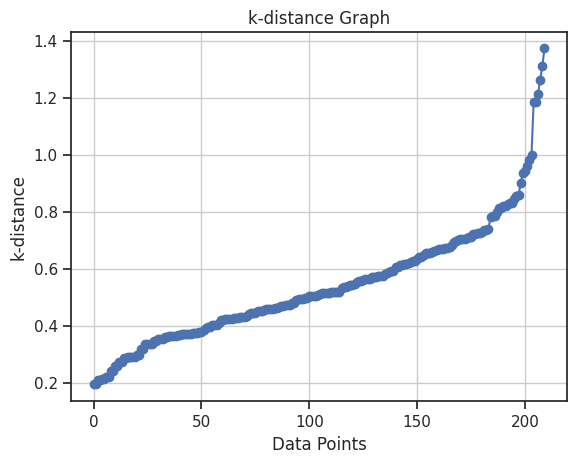

In [ ]:
# Calculate k-distances
neigh = NearestNeighbors(n_neighbors=2) # Consider k = 2 for the elbow method
nbrs = neigh.fit(bank_df_scaled)
distances, indices = nbrs.kneighbors(bank_df_scaled)

# Sort and plot distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, marker='o')
plt.xlabel("Data Points")
plt.ylabel("k-distance")
plt.title("k-distance Graph")
plt.grid()
plt.show()

**Interpreting the k-distance Graph for DBSCAN Epsilon Selection**

The k-distance graph is a useful tool for visually estimating an optimal epsilon value for DBSCAN clustering. Here's how to interpret it:

**Understanding the Graph:**

- The graph plots the distance to the k-th nearest neighbor for each data point in our dataset.
- The x-axis represents data points sorted by these distances in ascending order.
- The y-axis represents the actual k-distance.

**Identifying the Elbow Point:**

- The most crucial aspect is identifying the "elbow point," a sudden change in the slope of the curve.
- This point indicates a distance threshold where distances to the k-th nearest neighbor start increasing more rapidly.

**Optimal Epsilon:**

- The epsilon value is often chosen near the elbow point.
- This is because the elbow represents a natural distance scale:
    - Points within this distance are relatively close and likely to belong to the same cluster.
    - Points beyond this distance are farther apart and might belong to different clusters or be noise.

**Reasoning:**

- Selecting epsilon around the elbow point balances:
    - **Cluster Density:** Points within the elbow distance form denser regions suitable for clustering.
    - **Cluster Separation:** Points beyond the elbow distance are more spread out, suggesting different clusters or noise.

**Important Considerations:**

- **k Value:** The choice of k (number of nearest neighbors) affects the graph. A common choice is k=4 or k=5.
- **Data Scale:** Ensure our data is scaled appropriately before generating the graph to prevent feature dominance.
- **Visualization:** Visualize the resulting clusters with different epsilon values to assess their quality and interpretability.

Estimated number of clusters: 3
Estimated number of noise points: 39


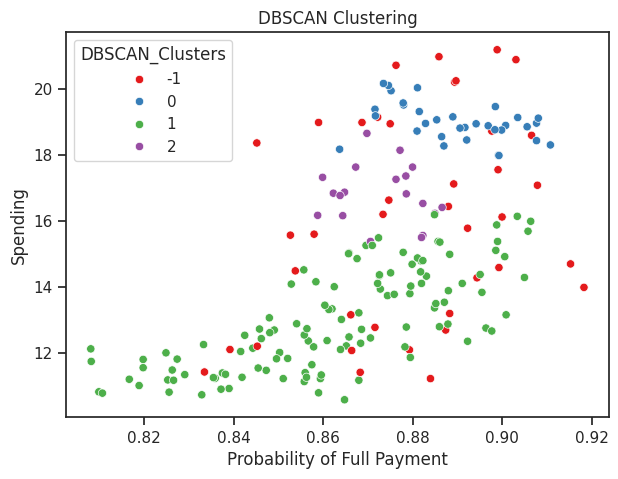

In [ ]:
# Initialize DBSCAN with parameters
dbscan = DBSCAN(eps=0.83, min_samples=4)  # Adjust eps and min_samples as needed

# Fit DBSCAN to the scaled data
dbscan.fit(bank_df_scaled)

# Get cluster labels
labels = dbscan.labels_

# Add cluster labels to the original DataFrame
bank_df['DBSCAN_Clusters'] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the number of clusters and noise points
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Visualize the clusters (optional)
plt.figure(figsize=(7, 5))
sns.scatterplot(data=bank_df, x='probability_of_full_payment', y='spending', hue='DBSCAN_Clusters', palette='Set1')
plt.title('DBSCAN Clustering')
plt.xlabel('Probability of Full Payment')
plt.ylabel('Spending')
plt.show()

In [ ]:
DBSCAN_Clusters_Freq = bank_df['DBSCAN_Clusters'].value_counts().sort_index()
DBSCAN_Clusters_Freq

,count
DBSCAN_Clusters,
-1,39
0,33
1,119
2,19


In [ ]:
# Create DBSCAN Cluster profile
DBSCAN_clust_profile=bank_df.drop(columns=['H_Clusters','K_Clusters']).groupby('DBSCAN_Clusters').mean()
DBSCAN_clust_profile['DBSCAN_Clusters_Freq']=bank_df['DBSCAN_Clusters'].value_counts().sort_index()
DBSCAN_clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,DBSCAN_Clusters_Freq
DBSCAN_Clusters,,,,,,,,
-1,16.062821,15.073590,0.879836,5.776282,3.422359,3.867567,5.537436,39
0,18.986970,16.374545,0.889867,6.223788,3.771152,2.825848,6.082758,33
1,12.989328,13.730000,0.862521,5.360395,3.028034,3.795984,5.106303,119
2,16.801579,15.544737,0.873184,5.970789,3.476368,4.275368,5.860737,19


**Insights from DBSCAN Cluster Profiles**

DBSCAN has identified four clusters, including a noise cluster (-1), with distinct characteristics:

**Cluster -1 (Noise):**

- Represents data points that DBSCAN could not assign to any specific cluster due to their low density or outlier nature.
- These customers have relatively moderate spending, advance payments, and probability of full payment, along with moderate credit limit and current balance. This cluster is the largest among all.

**Cluster 0:**

- Customers in this cluster exhibit the highest spending, advance payments, current balance, and maximum spending in single shopping trips.
- They also have a high probability of full payment, suggesting responsible financial behavior despite high spending.
- This segment might represent our most valuable customers.

**Cluster 1:**

- This cluster shows the lowest spending, advance payments, current balance, and maximum spent in single shopping compared to the other clusters.
- They have a relatively moderate probability of full payment but the lowest credit limits among all clusters.
- This cluster could consist of customers who are cautious with their credit card usage or have lower financial capacity, making them less valuable compared to other clusters.

**Cluster 2:**

- Customers in this cluster have moderate spending, advance payments, probability of full payment, and credit limit compared to other clusters.
- They have slightly higher current balances and minimum payment amounts than those in Cluster 1.
- This cluster has the lowest frequency among all clusters, indicating it could represent a smaller segment of customers who manage their credit card usage in a more balanced manner.

**Overall Insights**

- DBSCAN has identified a distinct group of high-value customers (Cluster 0) with high spending and a high probability of full payment.
- Cluster 1 represents customers with lower spending and credit utilization.
- Cluster 2 has the minimum number of data points and might be insignificant in drawing insights.
- The noise cluster (-1) comprises a significant portion of the data, highlighting the importance of outlier detection and data preprocessing.

**Potential Actions**

- **Target Cluster 0 with premium offers and rewards.**
- **Consider credit limit increases for customers in Cluster 1.**
- **Monitor Cluster -1

#### **5d. Gaussian Means Clustering**

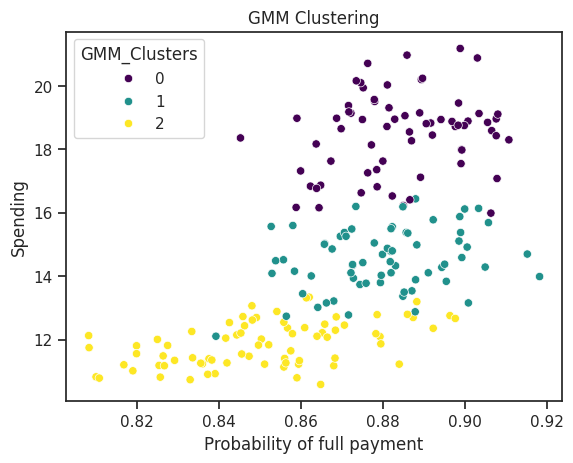

In [ ]:
# Initialize the GMM model
gmm = GaussianMixture(n_components=3, random_state=0)

# Fit the GMM model to the scaled data
gmm.fit(bank_df_scaled)

# Predict the cluster assignments
cluster_labels = gmm.predict(bank_df_scaled)

# Add the cluster labels to the original DataFrame
bank_df['GMM_Clusters'] = cluster_labels

# Scatter plot visualization using sns.scatterplot
sns.scatterplot(x='probability_of_full_payment', y='spending', hue='GMM_Clusters', data=bank_df, palette='viridis')
plt.title('GMM Clustering')
plt.ylabel('Spending')
plt.xlabel('Probability of full payment')
plt.show()

In [ ]:
GMM_Clusters_Freq = bank_df['GMM_Clusters'].value_counts().sort_index()
GMM_Clusters_Freq

,count
GMM_Clusters,
0,67
1,68
2,75


In [ ]:
# Create GMM Cluster Profile
GMM_clust_profile=bank_df.drop(columns=['H_Clusters','K_Clusters', 'DBSCAN_Clusters']).groupby('GMM_Clusters').mean()
GMM_clust_profile['GMM_Clusters_Freq']=bank_df['GMM_Clusters'].value_counts().sort_index()
GMM_clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,GMM_Clusters_Freq
GMM_Clusters,,,,,,,,
0,18.501791,16.203433,0.884570,6.169522,3.700134,3.607955,6.031209,67
1,14.529706,14.397353,0.880065,5.546544,3.266529,2.758121,5.142500,68
2,11.871200,13.237333,0.850655,5.219587,2.856987,4.636760,5.092187,75


**Insights from GMM Clustering**

**Cluster 0: High Spenders, High Advance Payments, Good Payment Probability**

* **Characteristics:** This cluster represents customers with the highest spending and advance payment behavior. They also have a relatively high probability of full payment and maintain a higher current balance.
* **Interpretation:** These are potentially our most valuable customers, as they spend and pay more. They might be less price-sensitive and more likely to respond to premium offers or loyalty programs.
* **Potential Strategies:** Target them with exclusive promotions, personalized recommendations, and higher credit limits to encourage further spending.


**Cluster 1: Moderate Spenders, Moderate Advance Payments, Good Payment Probability**

* **Characteristics:** This cluster shows moderate spending and advance payment behavior. Their probability of full payment is similar to Cluster 0, but they have lower current balances and credit limits.
* **Interpretation:** These customers are reliable and make consistent payments. They might be more price-conscious than Cluster 0 and could be attracted by discounts and rewards programs.
* **Potential Strategies:** Offer them targeted promotions, encourage them to increase their spending, and consider offering credit limit increases based on their payment history.


**Cluster 2: Low Spenders, Moderate Advance Payments, Lower Payment Probability**

* **Characteristics:** This cluster has the lowest spending and a lower probability of full payment compared to the other clusters. Interestingly, they still make moderate advance payments but have lower credit limits and higher minimum payment amounts.
* **Interpretation:** These customers might be more cautious with their spending and potentially have a higher risk of default. It is crucial to monitor their payment behavior closely.
* **Potential Strategies:** Offer them financial education resources, promote budget-friendly products or services, and consider lower credit limits or stricter payment terms to mitigate risk.

Overall, the GMM clustering has revealed three distinct customer segments with varying spending patterns and payment behaviors. By understanding these cluster profiles, the bank can develop targeted marketing strategies to better serve each customer group and optimize its promotional efforts.

### **Comprehensive Business Recommendations based on Multiple Clustering Analyses**

By combining insights from Hierarchical, KMeans, DBSCAN, and GMM clustering, we can develop a more robust and nuanced understanding of customer behavior and generate highly effective business recommendations. This comprehensive approach considers different clustering perspectives to identify key customer segments and their specific needs.

**Overall Business Recommendations**

**1. Customer Segmentation and Targeting:**

* **High-Value Customers:** This segment, consistently identified across multiple clustering methods, represents customers with high spending, advance payments, and good payment probability. Focus on personalized premium offers, credit limit increases, investment and wealth management services, and concierge services to cater to their needs and foster loyalty.
* **Reliable Customers:** This segment, also consistently identified, includes customers with moderate spending, advance payments, and good payment probability. Offer targeted promotions and rewards, optimize credit limits, provide financial planning and education, and explore cross-selling and upselling opportunities.
* **Risk-Prone Customers:** This segment, consistently identified, consists of customers with low spending, lower payment probability, and potentially higher risk of default. Prioritize financial education and support, promote budget-friendly options, implement risk mitigation strategies, and offer credit counseling or debt management services.
* **Unique Segments:** If any clustering method reveals unique segments not identified by others, further investigate their characteristics and behaviors to develop tailored strategies. This might involve a combination of recommendations from different segments or entirely new approaches.
* **Outlier Handling:** If DBSCAN identifies outliers, carefully analyze their characteristics to understand their behavior and potential value. Some outliers might represent niche segments with unique needs, while others might require risk mitigation strategies.

**2. Product and Service Development:**

* **Premium Offerings:** Develop and promote premium products and services tailored to high-value customers, such as exclusive credit cards, personalized investment solutions, and concierge services.
* **Budget-Friendly Options:** Offer budget-friendly product options and flexible payment plans to cater to risk-prone customers, ensuring financial inclusivity and accessibility.
* **Financial Education and Planning Tools:** Develop and promote financial education resources and planning tools accessible to all customer segments, empowering them to make informed financial decisions and manage their finances effectively.
* **Niche Products:** Consider developing niche products and services to cater to unique segments identified by specific clustering methods, addressing their specific needs and preferences.

**3. Marketing and Communication Strategies:**

* **Personalized Communication:** Leverage customer data and insights from all clustering analyses to personalize marketing messages and communication strategies for each segment. Tailor offers, promotions, and content to resonate with their specific needs and preferences.
* **Multi-Channel Engagement:** Engage customers through multiple channels, including email, mobile, social media, and in-person interactions, to build stronger relationships and deliver relevant information.
* **Customer Feedback and Surveys:** Actively collect customer feedback through surveys, focus groups, and online reviews to gain insights into their evolving needs and preferences. This feedback can inform product development, marketing strategies, and customer service improvements.

**4. Risk Management and Fraud Prevention:**

* **Credit Scoring and Risk Assessment:** Enhance credit scoring and risk assessment models by incorporating insights from all clustering analyses to better identify and manage potential risks associated with different customer segments.
* **Fraud Detection and Prevention:** Implement robust fraud detection and prevention systems to monitor transactions and identify suspicious activities, particularly for risk-prone customers and outliers identified by DBSCAN.
* **Early Warning Systems:** Develop early warning systems to identify customers who are showing signs of financial distress or potential default. This allows for proactive intervention and support to mitigate losses.

**5. Operational Efficiency and Customer Service:**

* **Customer Relationship Management (CRM):** Implement or enhance a CRM system to track customer interactions, preferences, and segment assignments from all clustering analyses. This enables personalized communication, targeted marketing efforts, and efficient customer service.
* **Data Analytics and Business Intelligence:** Leverage data analytics and business intelligence tools to monitor key performance indicators (KPIs), track campaign effectiveness, and identify areas for improvement based on insights from all clustering methods.
* **Customer Service Training:** Train customer service representatives to understand the unique needs and preferences of each customer segment, enabling them to provide personalized and effective support.

By implementing these comprehensive business recommendations based on insights from Hierarchical, KMeans, DBSCAN, and GMM clustering analyses, the bank can achieve a holistic view of its customer base, optimize its operations, enhance customer relationships, mitigate risks, and drive sustainable business growth. Remember to continuously monitor customer behavior, refine the clustering models over time, and adapt strategies to stay ahead of evolving customer needs and market trends.